# Model comparison benchmark - result analysis

In [27]:
# Setup
import pandas as pd
import toytree as tt
import numpy as np
import arviz as az
import anndata as ad
import os
import pickle as pkl
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [28]:
def get_scores(df):
    """
    Calculates extended binary classification summary statistics, such as TPR, TNR, youden index, f1-score, MCC

    Parameters
    ----------
    df: DataFrame
        Must contain columns tp, tn, fp, fn

    Returns
    -------
    df: DataFrame
        Same df with added columns tpr, tnr, precision, accuracy, youden, f1_score, mcc
    """
    tp = df["tp"].astype("float64")
    tn = df["tn"].astype("float64")
    fp = df["fp"].astype("float64")
    fn = df["fn"].astype("float64")

    tpr = (tp / (tp + fn)).fillna(0)
    df["tpr"] = tpr
    tnr = (tn / (tn + fp)).fillna(0)
    df["tnr"] = tnr
    precision = (tp / (tp + fp)).fillna(0)
    df["precision"] = precision
    fdr = (fp / (tp + fp)).fillna(0)
    df["fdr"] = fdr
    acc = ((tp + tn) / (tp + tn + fp + fn)).fillna(0)
    df["accuracy"] = acc

    df["youden"] = tpr + tnr - 1
    df["f1_score"] = 2 * (tpr * precision / (tpr + precision)).fillna(0)

    df["mcc"] = (((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))).fillna(0)

    return df


def classify(row):
    gt = np.zeros(row["num_otus"])
    if type(row["effect_otus"]) == str:
        eff = eval(row["effect_otus"].replace("[ ", "[").replace("  ", " ").replace(" ", ", "))
    else:
        eff = row["effect_otus"]
    gt[eff] = 1

    pred = np.zeros(row["num_otus"])
    res = [int(x) for x in eval(row["result_otus"])]
    pred[res] = 1

    tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()
    return tp, tn, fp, fn

In [29]:
dfs = {}
models = ["adaANCOM", "ANCOM", "ANCOMBC", "ALDEx2", "alr_ttest", "alr_wilcoxon"]
# models = ["adaANCOM"]

results_path = "./results_models3/"

for m in models:
    df = pd.read_csv(results_path + f"result_df_{m}.csv", index_col=0)

    classes = df.apply(classify, axis=1)

    df["tp"] = [x[0] for x in classes]
    df["tn"] = [x[1] for x in classes]
    df["fp"] = [x[2] for x in classes]
    df["fn"] = [x[3] for x in classes]
    df = get_scores(df)

    dfs[m] = df

In [30]:
all_dfs = pd.concat(dfs.values())
all_dfs

model result_nodes                     result_otus  dataset_id  \
0         adaANCOM           []                              []           0   
1         adaANCOM       ['12']                      ['9', '7']           1   
2         adaANCOM           []                              []           2   
3         adaANCOM           []                              []           3   
4         adaANCOM           []                              []           4   
...            ...          ...                             ...         ...   
1275  alr_wilcoxon           []                [56, 57, 58, 72]        1275   
1276  alr_wilcoxon           []            [28, 55, 56, 57, 72]        1276   
1277  alr_wilcoxon           []            [28, 55, 56, 58, 72]        1277   
1278  alr_wilcoxon           []                              []        1278   
1279  alr_wilcoxon           []  [0, 9, 28, 55, 56, 57, 58, 72]        1279   

       effect_nodes          effect_otus  num_samples  effect_size  num_otus  \
0        [12  4  0]            [8 0 4 7]            5          0.3        10   
1        [12  4  0]            [8 0 4 7]            5          0.3        10   
2        [12  4  0]            [8 0 4 7]            5          0.3        10   
3        [12  4  0]            [8 0 4 7]            5          0.3        10   
4        [12  4  0]            [8 0 4 7]            5          0.3        10   
...             ...                  ...          ...          ...       ...   
1275  [113  72  28]  [72 55 56 57 58 28]           50          0.9       100   
1276  [113  72  28]  [72 55 56 57 58 28]           50          0.9       100   
1277  [113  72  28]  [72 55 56 57 58 28]           50          0.9       100   
1278  [113  72  28]  [72 55 56 57 58 28]           50          0.9       100   
1279  [113  72  28]  [72 55 56 57 58 28]           50          0.9       100   

      tp  ...  fp  fn       tpr       tnr  precision   fdr  accuracy  \
0      0  ...   0   4  0.000000  1.000000       0.00  0.00      0.60   
1      1  ...   1   3  0.250000  0.833333       0.50  0.50      0.60   
2      0  ...   0   4  0.000000  1.000000       0.00  0.00      0.60   
3      0  ...   0   4  0.000000  1.000000       0.00  0.00      0.60   
4      0  ...   0   4  0.000000  1.000000       0.00  0.00      0.60   
...   ..  ...  ..  ..       ...       ...        ...   ...       ...   
1275   4  ...   0   2  0.666667  1.000000       1.00  0.00      0.98   
1276   5  ...   0   1  0.833333  1.000000       1.00  0.00      0.99   
1277   5  ...   0   1  0.833333  1.000000       1.00  0.00      0.99   
1278   0  ...   0   6  0.000000  1.000000       0.00  0.00      0.94   
1279   6  ...   2   0  1.000000  0.978723       0.75  0.25      0.98   

        youden  f1_score       mcc  
0     0.000000  0.000000  0.000000  
1     0.083333  0.333333  0.102062  
2     0.000000  0.000000  0.000000  
3     0.000000  0.000000  0.000000  
4     0.000000  0.000000  0.000000  
...        ...       ...       ...  
1275  0.666667  0.800000  0.807947  
1276  0.833333  0.909091  0.908054  
1277  0.833333  0.909091  0.908054  
1278  0.000000  0.000000  0.000000  
1279  0.978723  0.857143  0.856763  

[7680 rows x 21 columns]

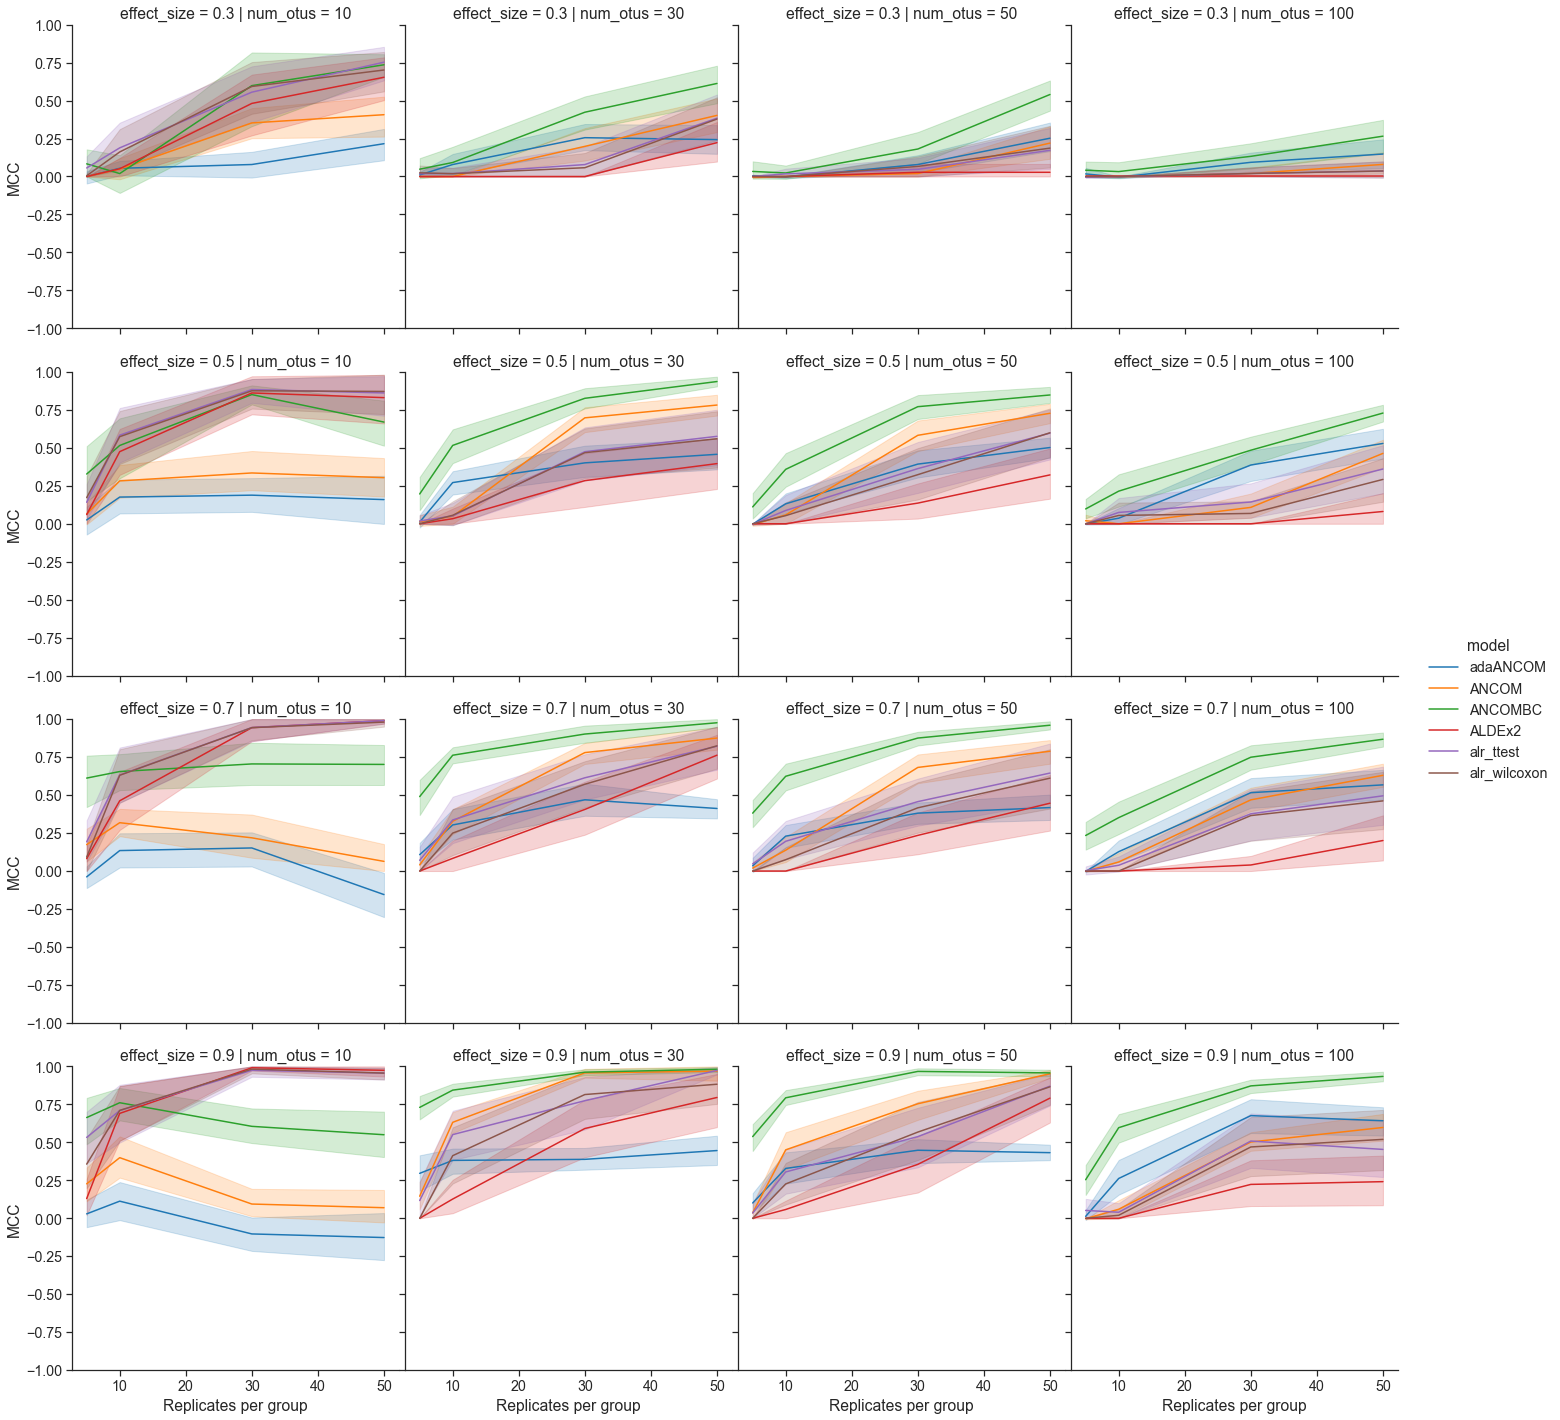

In [5]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=all_dfs, x="num_samples", y="mcc",
                hue="model",
                palette="tab10",
                col="num_otus",
                row="effect_size",
                kind="line",
                legend=True,
            )
g.set(ylim=[-1,1])

# g.axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,)

(g.set_axis_labels("Replicates per group", "MCC").tight_layout(w_pad=0))
plt.show()


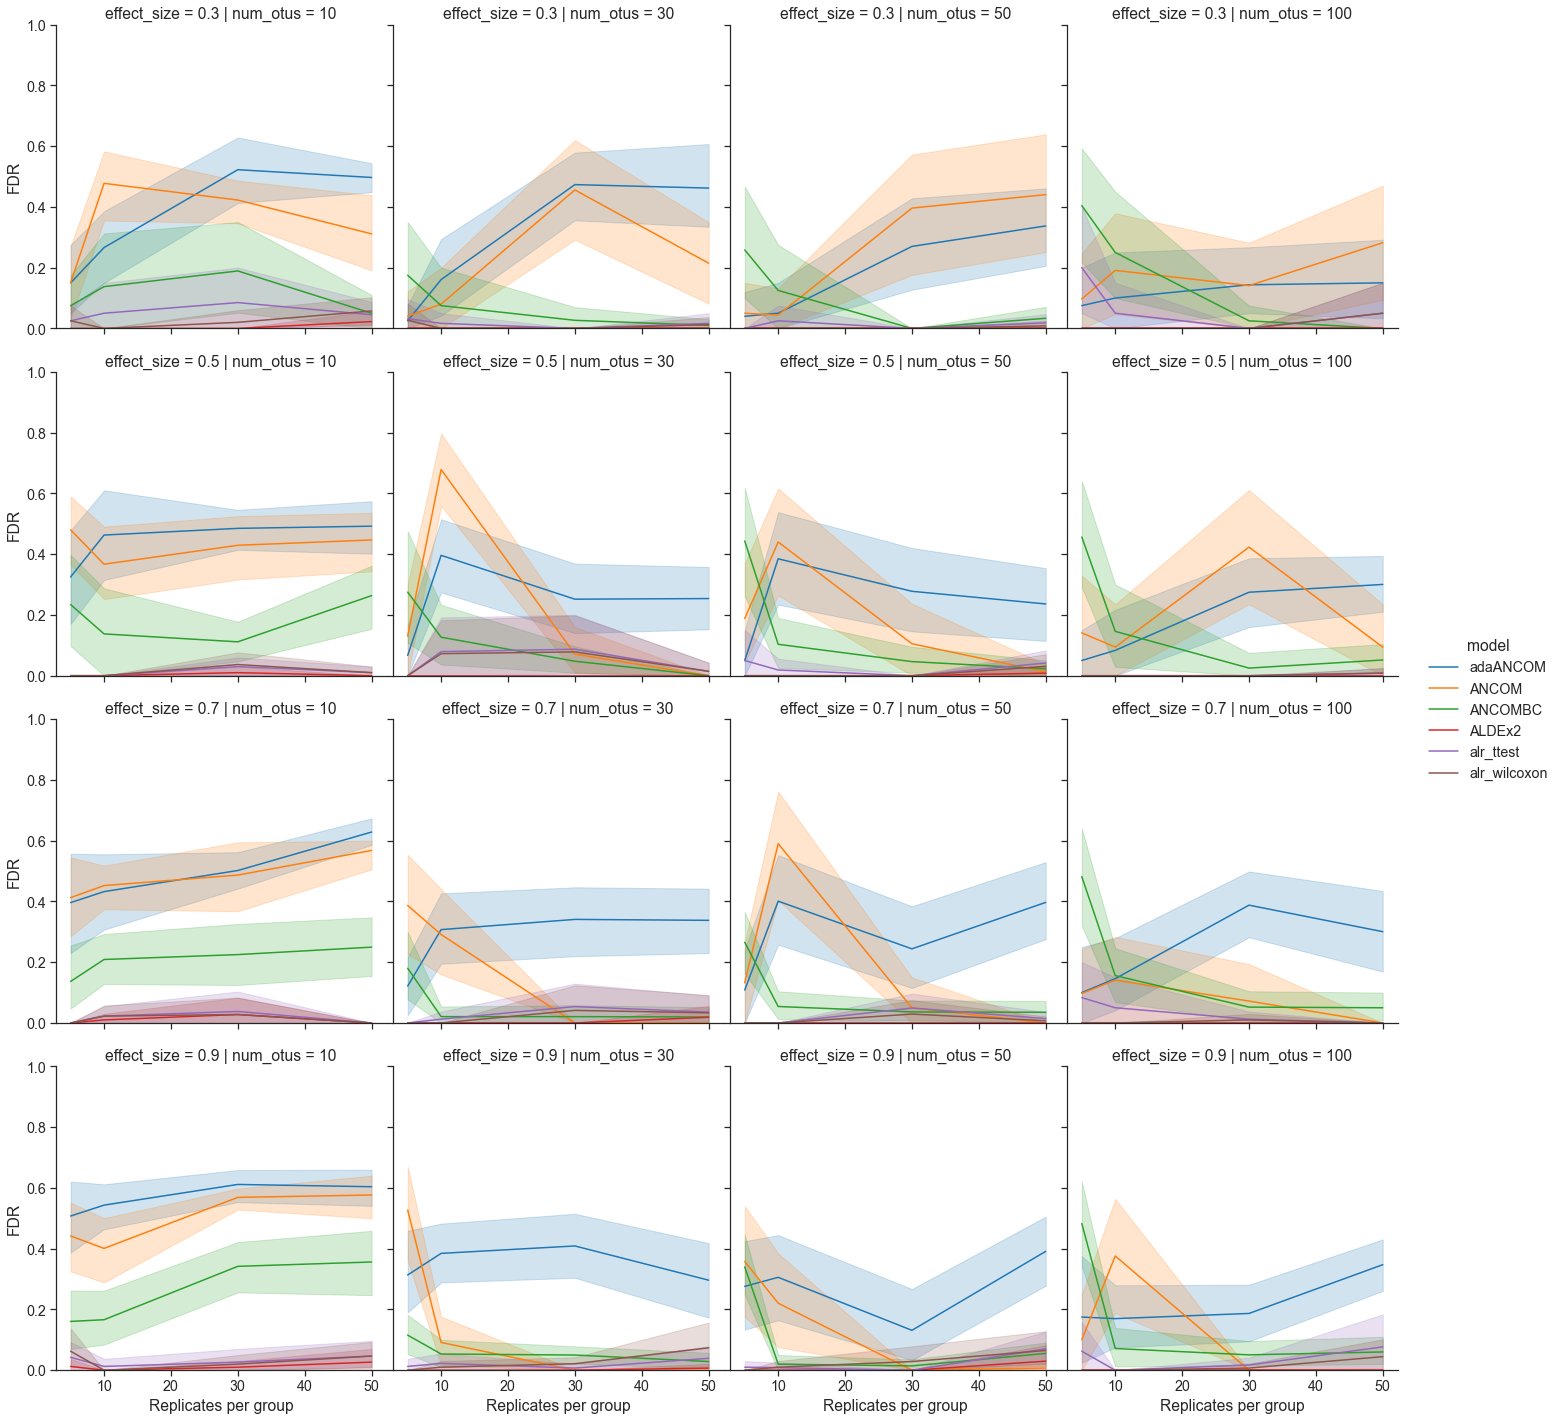

In [6]:
g = sns.relplot(data=all_dfs, x="num_samples", y="fdr",
                hue="model",
                palette="tab10",
                col="num_otus",
                row="effect_size",
                kind="line",
                legend=True
            )
g.set(ylim=[0,1])

# g.axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,)

(g.set_axis_labels("Replicates per group", "FDR").tight_layout(w_pad=0))
plt.show()

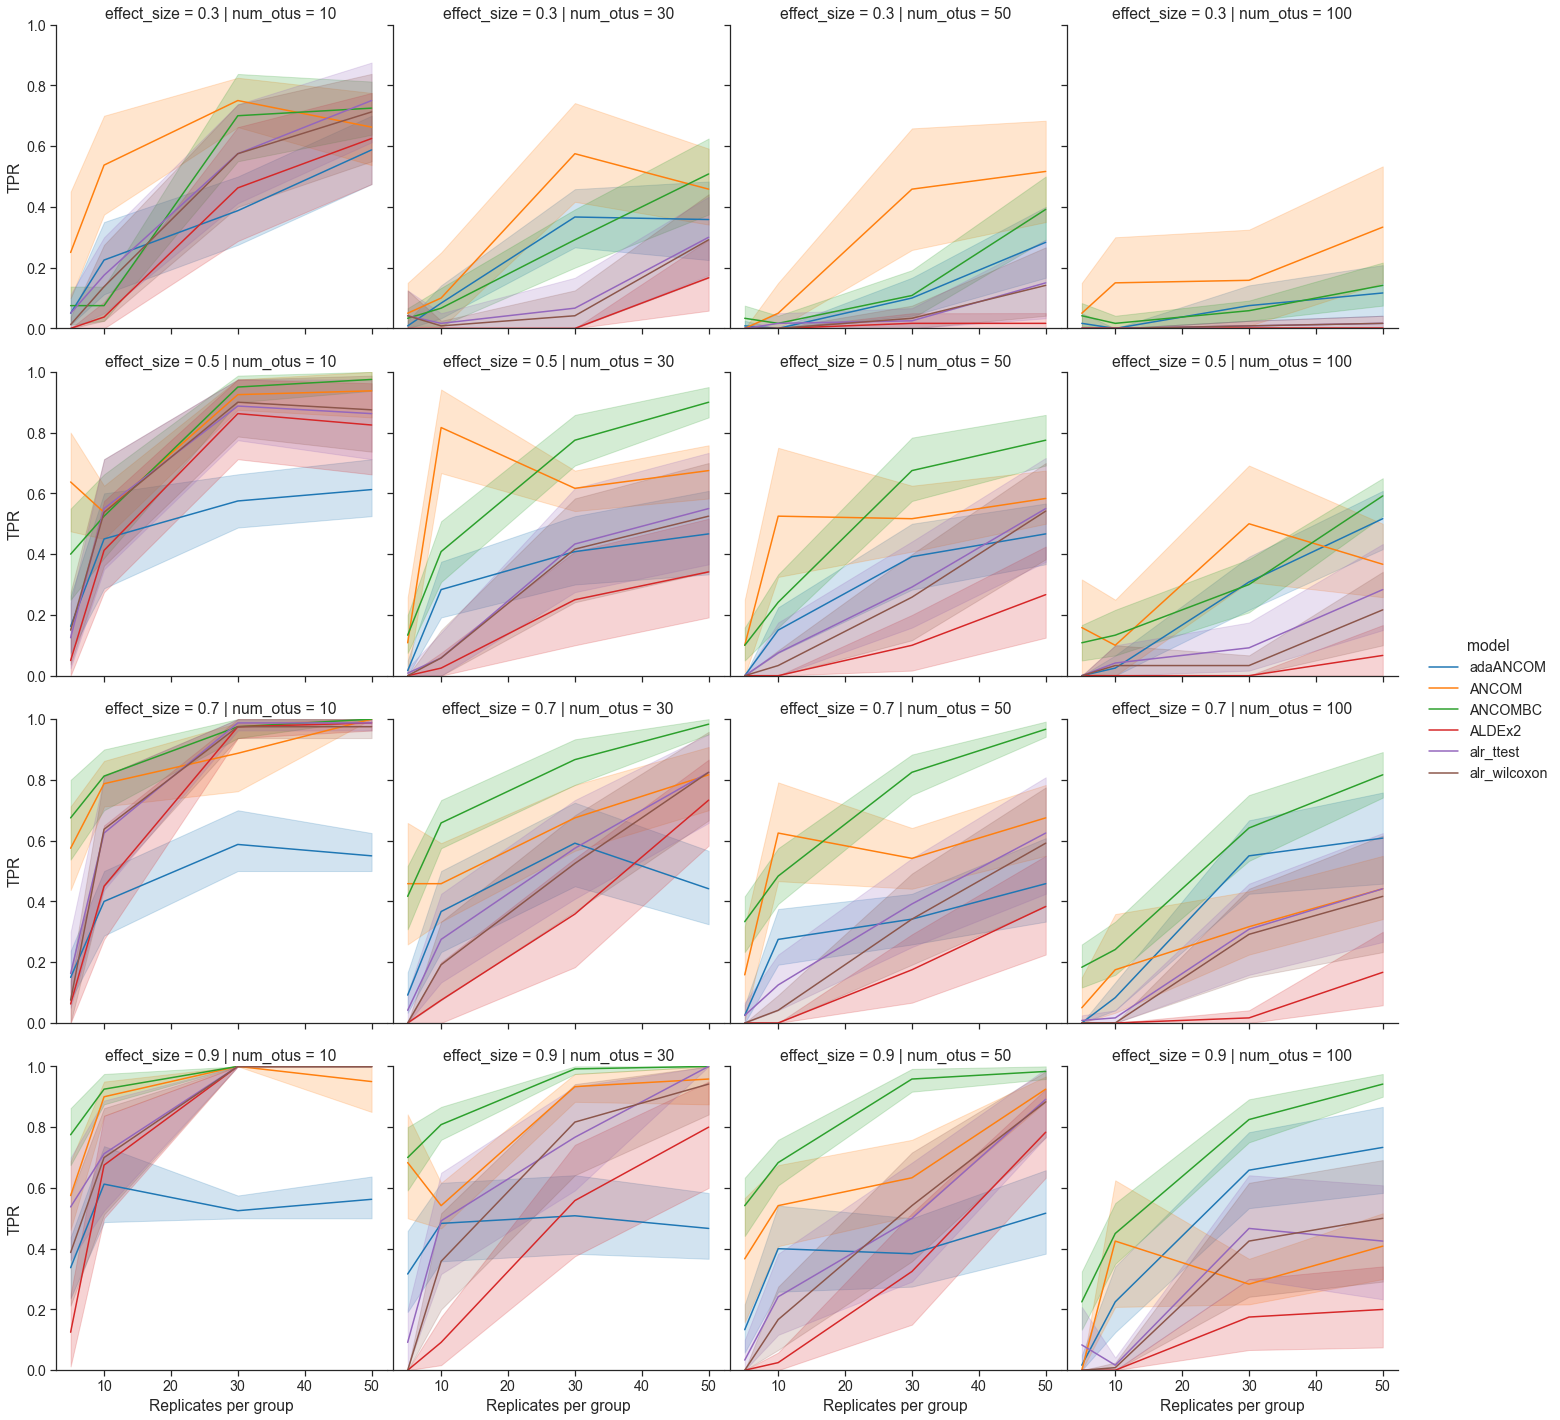

In [7]:
g = sns.relplot(data=all_dfs, x="num_samples", y="tpr",
                hue="model",
                palette="tab10",
                col="num_otus",
                row="effect_size",
                kind="line",
                legend=True
            )
g.set(ylim=[0,1])

# g.axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,)

(g.set_axis_labels("Replicates per group", "TPR").tight_layout(w_pad=0))
plt.show()

## Add tree_agg

In [31]:
tree_agg_path = results_path = "./results_bayes/results4/"

tree_agg_res = []

for f in os.listdir(tree_agg_path):
    if f.startswith("result_df"):
        tree_agg_res.append(pd.read_csv(tree_agg_path + f, index_col=0))

tree_agg_df = pd.concat(tree_agg_res)
tree_agg_df

model reg_method  lambda   phi result_nodes       result_otus  \
0   tree_agg      new_3     NaN   1.0           []                []   
1   tree_agg      new_3     NaN   1.0           []                []   
2   tree_agg      new_3     NaN   1.0       ['61']  [44, 45, 46, 47]   
3   tree_agg      new_3     NaN   1.0           []                []   
4   tree_agg      new_3     NaN   1.0           []                []   
..       ...        ...     ...   ...          ...               ...   
45  tree_agg      new_3     NaN  10.0       ['45']              [45]   
46  tree_agg      new_3     NaN  10.0       ['40']              [40]   
47  tree_agg      new_3     NaN  10.0           []                []   
48  tree_agg      new_3     NaN  10.0        ['5']               [5]   
49  tree_agg      new_3     NaN  10.0           []                []   

    mean_log_prob  acc_rate  num_samples  effect_size  num_otus  dataset_id  
0    -5633.074308   0.84925           10          0.5        50         750  
1    -5906.966826   0.85165           10          0.5        50         751  
2    -5935.814658   0.86305           10          0.5        50         752  
3    -6027.415502   0.84095           10          0.5        50         753  
4    -5912.660682   0.84740           10          0.5        50         754  
..            ...       ...          ...          ...       ...         ...  
45   -5926.021540   0.85775           10          0.5        50         745  
46   -5834.394197   0.85165           10          0.5        50         746  
47   -5697.796030   0.84470           10          0.5        50         747  
48   -5917.720165   0.84350           10          0.5        50         748  
49   -5874.866712   0.84970           10          0.5        50         749  

[10240 rows x 12 columns]

In [32]:
ground_truth = {
    10: ([0, 4, 12], [0, 4, 7, 8]),
    30: ([33, 7, 0], [0, 7, 13, 14, 15, 16]),
    50: ([61, 40, 5], [5, 40, 44, 45, 46, 47]),
    100: ([113, 72, 28], [72, 55, 56, 57, 58, 28])
}

tree_agg_df["effect_nodes"] = [ground_truth[x][0] for x in tree_agg_df["num_otus"]]
tree_agg_df["effect_otus"] = [ground_truth[x][1] for x in tree_agg_df["num_otus"]]
tree_agg_df

model reg_method  lambda   phi result_nodes       result_otus  \
0   tree_agg      new_3     NaN   1.0           []                []   
1   tree_agg      new_3     NaN   1.0           []                []   
2   tree_agg      new_3     NaN   1.0       ['61']  [44, 45, 46, 47]   
3   tree_agg      new_3     NaN   1.0           []                []   
4   tree_agg      new_3     NaN   1.0           []                []   
..       ...        ...     ...   ...          ...               ...   
45  tree_agg      new_3     NaN  10.0       ['45']              [45]   
46  tree_agg      new_3     NaN  10.0       ['40']              [40]   
47  tree_agg      new_3     NaN  10.0           []                []   
48  tree_agg      new_3     NaN  10.0        ['5']               [5]   
49  tree_agg      new_3     NaN  10.0           []                []   

    mean_log_prob  acc_rate  num_samples  effect_size  num_otus  dataset_id  \
0    -5633.074308   0.84925           10          0.5        50         750   
1    -5906.966826   0.85165           10          0.5        50         751   
2    -5935.814658   0.86305           10          0.5        50         752   
3    -6027.415502   0.84095           10          0.5        50         753   
4    -5912.660682   0.84740           10          0.5        50         754   
..            ...       ...          ...          ...       ...         ...   
45   -5926.021540   0.85775           10          0.5        50         745   
46   -5834.394197   0.85165           10          0.5        50         746   
47   -5697.796030   0.84470           10          0.5        50         747   
48   -5917.720165   0.84350           10          0.5        50         748   
49   -5874.866712   0.84970           10          0.5        50         749   

   effect_nodes              effect_otus  
0   [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
1   [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
2   [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
3   [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
4   [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
..          ...                      ...  
45  [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
46  [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
47  [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
48  [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
49  [61, 40, 5]  [5, 40, 44, 45, 46, 47]  

[10240 rows x 14 columns]

In [33]:
classes = tree_agg_df.apply(classify, axis=1)

tree_agg_df["tp"] = [x[0] for x in classes]
tree_agg_df["tn"] = [x[1] for x in classes]
tree_agg_df["fp"] = [x[2] for x in classes]
tree_agg_df["fn"] = [x[3] for x in classes]
tree_agg_df = get_scores(tree_agg_df)
tree_agg_df

model reg_method  lambda   phi result_nodes       result_otus  \
0   tree_agg      new_3     NaN   1.0           []                []   
1   tree_agg      new_3     NaN   1.0           []                []   
2   tree_agg      new_3     NaN   1.0       ['61']  [44, 45, 46, 47]   
3   tree_agg      new_3     NaN   1.0           []                []   
4   tree_agg      new_3     NaN   1.0           []                []   
..       ...        ...     ...   ...          ...               ...   
45  tree_agg      new_3     NaN  10.0       ['45']              [45]   
46  tree_agg      new_3     NaN  10.0       ['40']              [40]   
47  tree_agg      new_3     NaN  10.0           []                []   
48  tree_agg      new_3     NaN  10.0        ['5']               [5]   
49  tree_agg      new_3     NaN  10.0           []                []   

    mean_log_prob  acc_rate  num_samples  effect_size  ...  fp  fn       tpr  \
0    -5633.074308   0.84925           10          0.5  ...   0   6  0.000000   
1    -5906.966826   0.85165           10          0.5  ...   0   6  0.000000   
2    -5935.814658   0.86305           10          0.5  ...   0   2  0.666667   
3    -6027.415502   0.84095           10          0.5  ...   0   6  0.000000   
4    -5912.660682   0.84740           10          0.5  ...   0   6  0.000000   
..            ...       ...          ...          ...  ...  ..  ..       ...   
45   -5926.021540   0.85775           10          0.5  ...   0   5  0.166667   
46   -5834.394197   0.85165           10          0.5  ...   0   5  0.166667   
47   -5697.796030   0.84470           10          0.5  ...   0   6  0.000000   
48   -5917.720165   0.84350           10          0.5  ...   0   5  0.166667   
49   -5874.866712   0.84970           10          0.5  ...   0   6  0.000000   

    tnr  precision  fdr  accuracy    youden  f1_score       mcc  
0   1.0        0.0  0.0      0.88  0.000000  0.000000  0.000000  
1   1.0        0.0  0.0      0.88  0.000000  0.000000  0.000000  
2   1.0        1.0  0.0      0.96  0.666667  0.800000  0.798549  
3   1.0        0.0  0.0      0.88  0.000000  0.000000  0.000000  
4   1.0        0.0  0.0      0.88  0.000000  0.000000  0.000000  
..  ...        ...  ...       ...       ...       ...       ...  
45  1.0        1.0  0.0      0.90  0.166667  0.285714  0.386859  
46  1.0        1.0  0.0      0.90  0.166667  0.285714  0.386859  
47  1.0        0.0  0.0      0.88  0.000000  0.000000  0.000000  
48  1.0        1.0  0.0      0.90  0.166667  0.285714  0.386859  
49  1.0        0.0  0.0      0.88  0.000000  0.000000  0.000000  

[10240 rows x 26 columns]

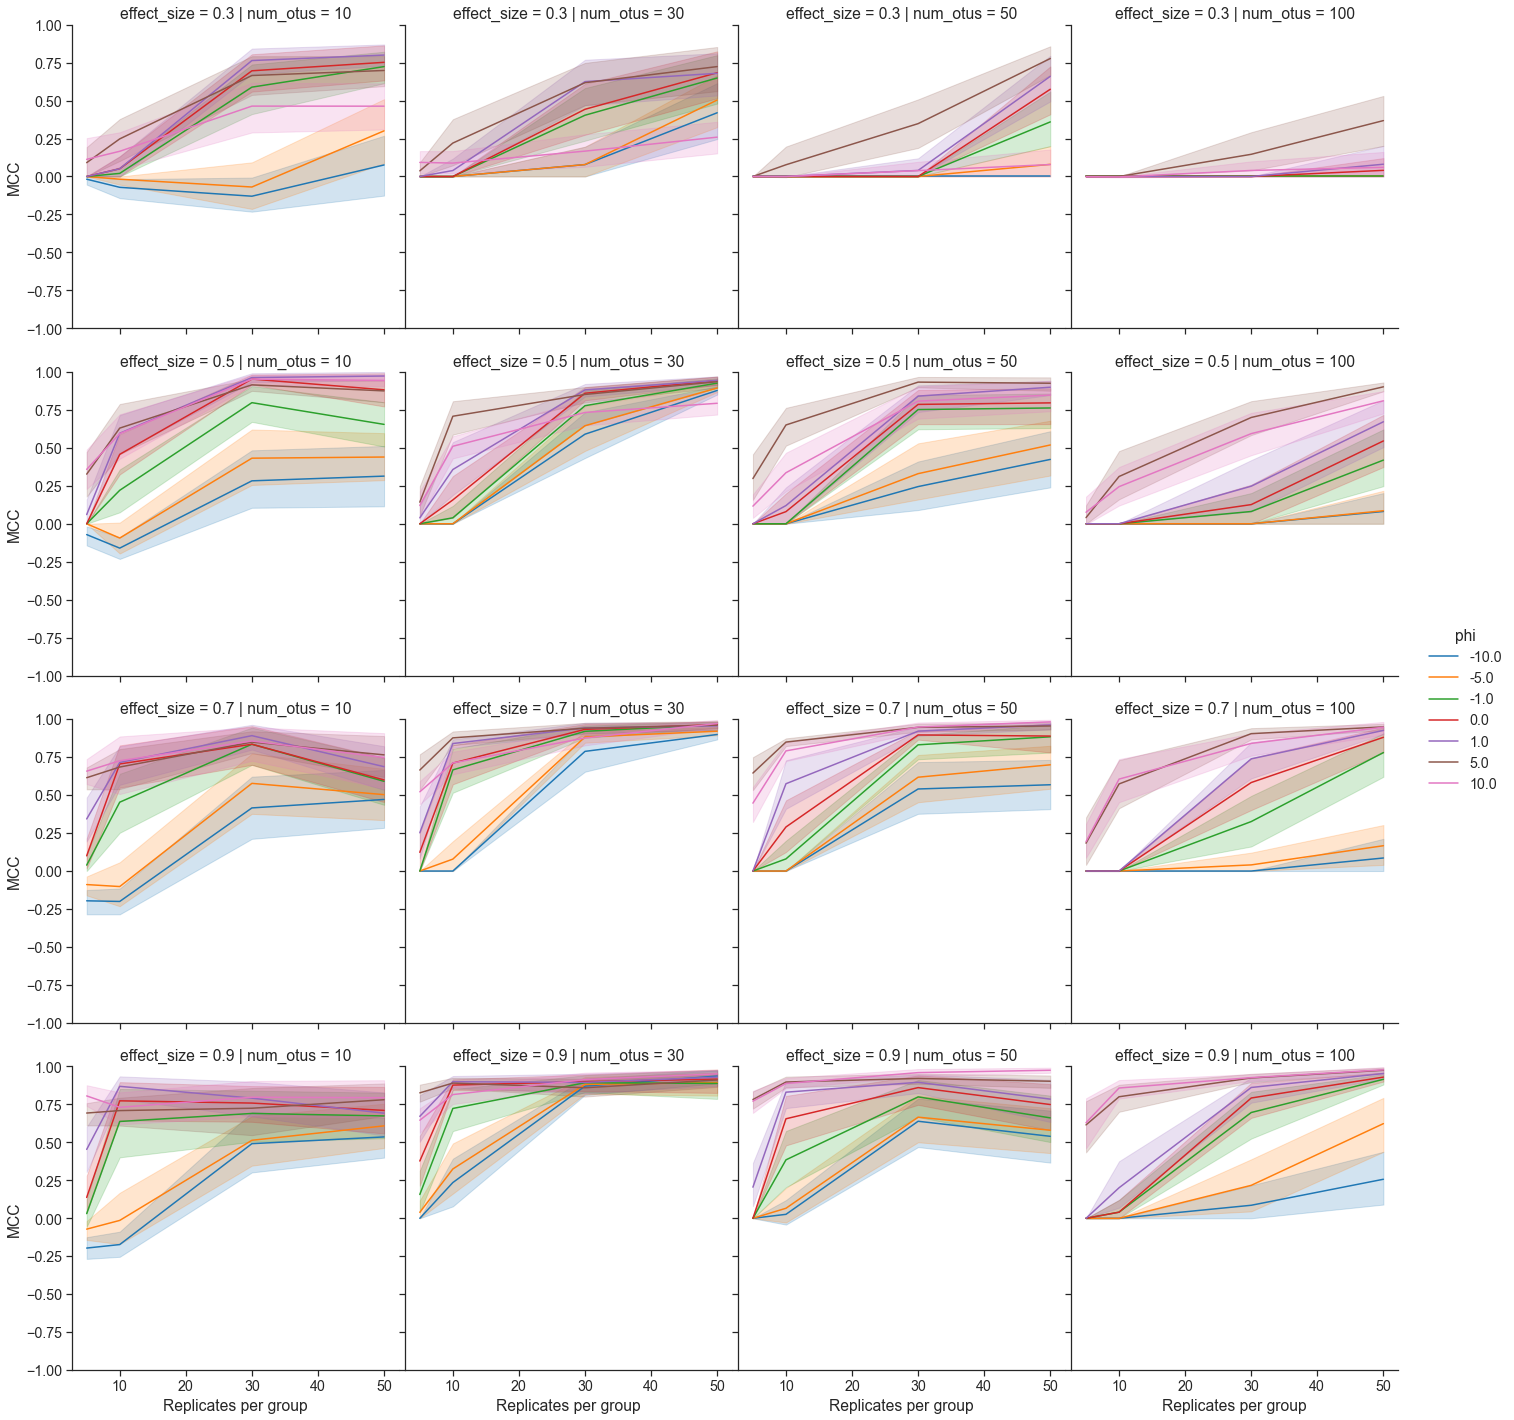

In [11]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=tree_agg_df, x="num_samples", y="mcc",
                hue="phi",
                palette="tab10",
                col="num_otus",
                row="effect_size",
                kind="line",
                legend=True,
            )
g.set(ylim=[-1,1])

# g.axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,)

(g.set_axis_labels("Replicates per group", "MCC").tight_layout(w_pad=0))
plt.show()


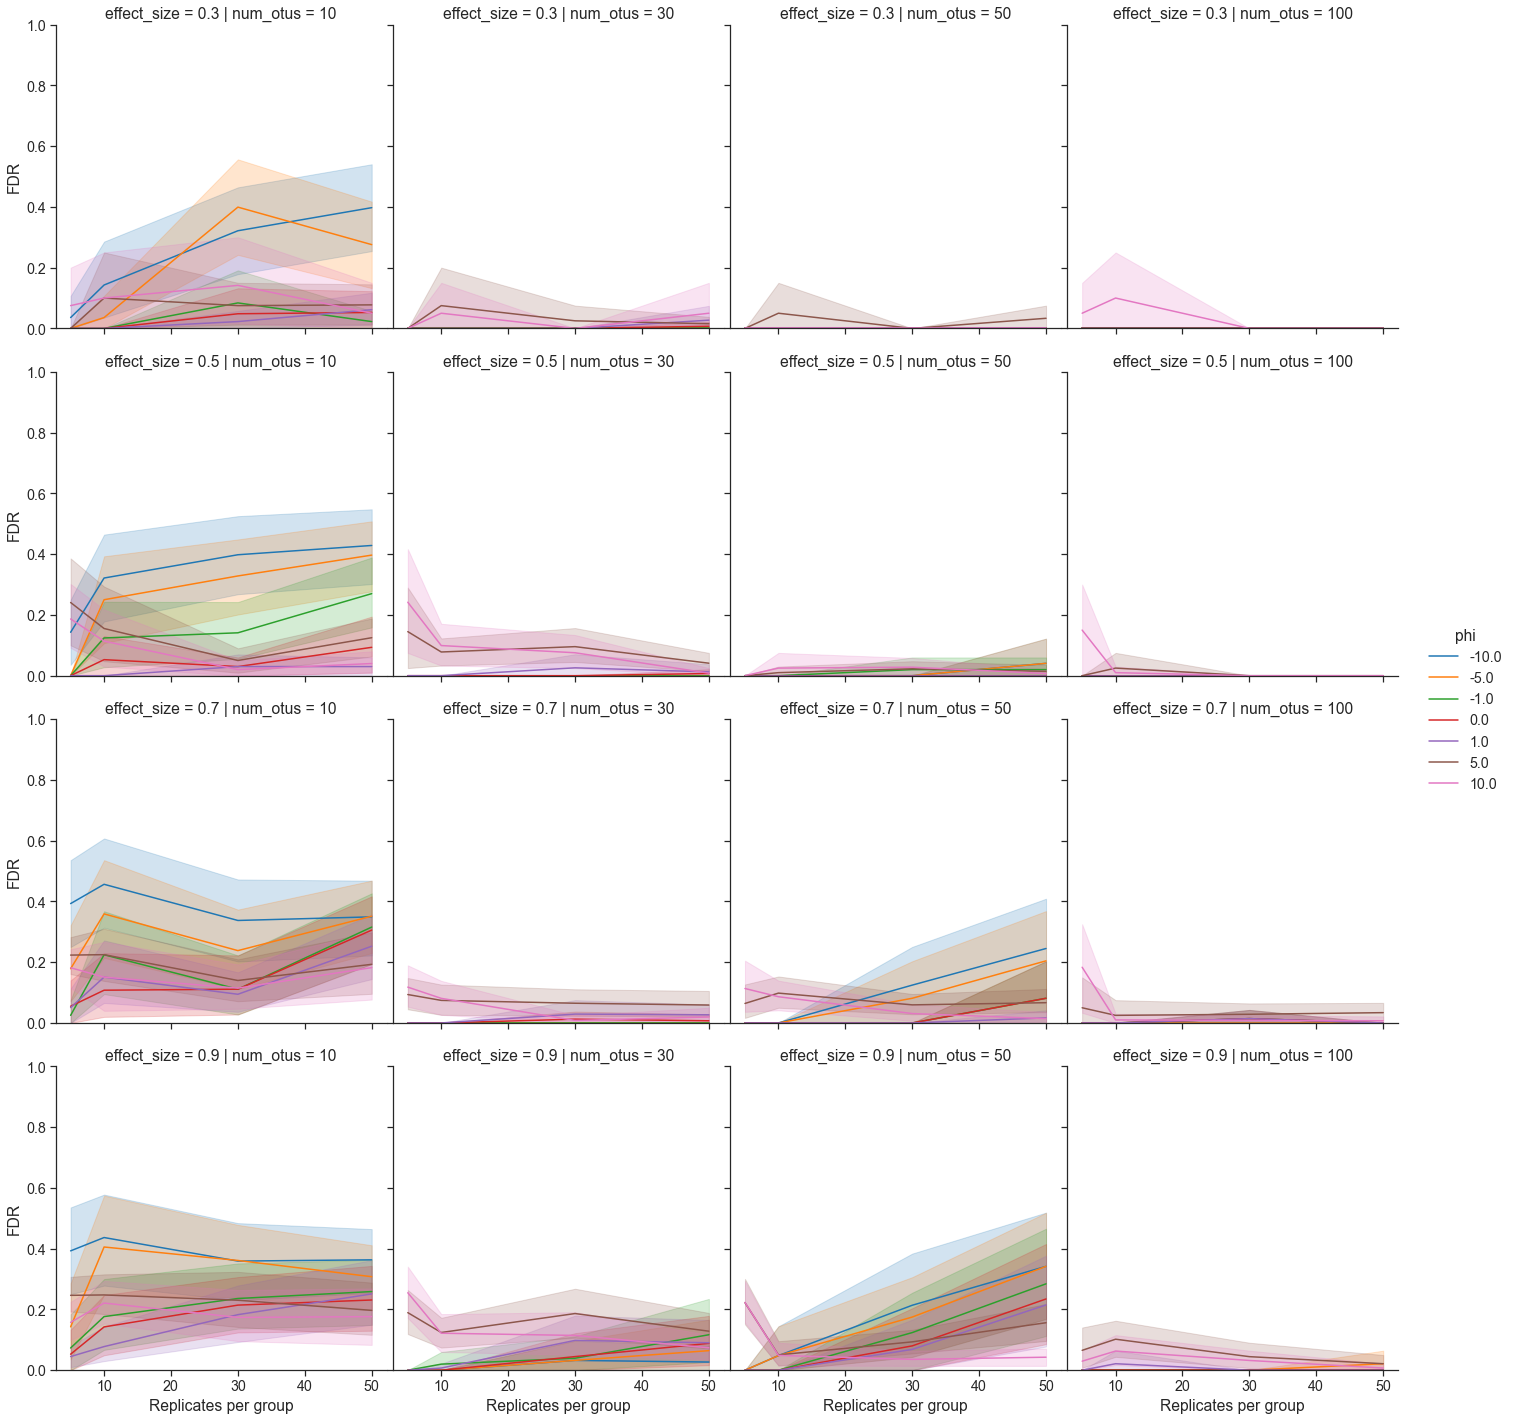

In [12]:
g = sns.relplot(data=tree_agg_df, x="num_samples", y="fdr",
                hue="phi",
                palette="tab10",
                col="num_otus",
                row="effect_size",
                kind="line",
                legend=True
            )
g.set(ylim=[0,1])

# g.axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,)

(g.set_axis_labels("Replicates per group", "FDR").tight_layout(w_pad=0))
plt.show()

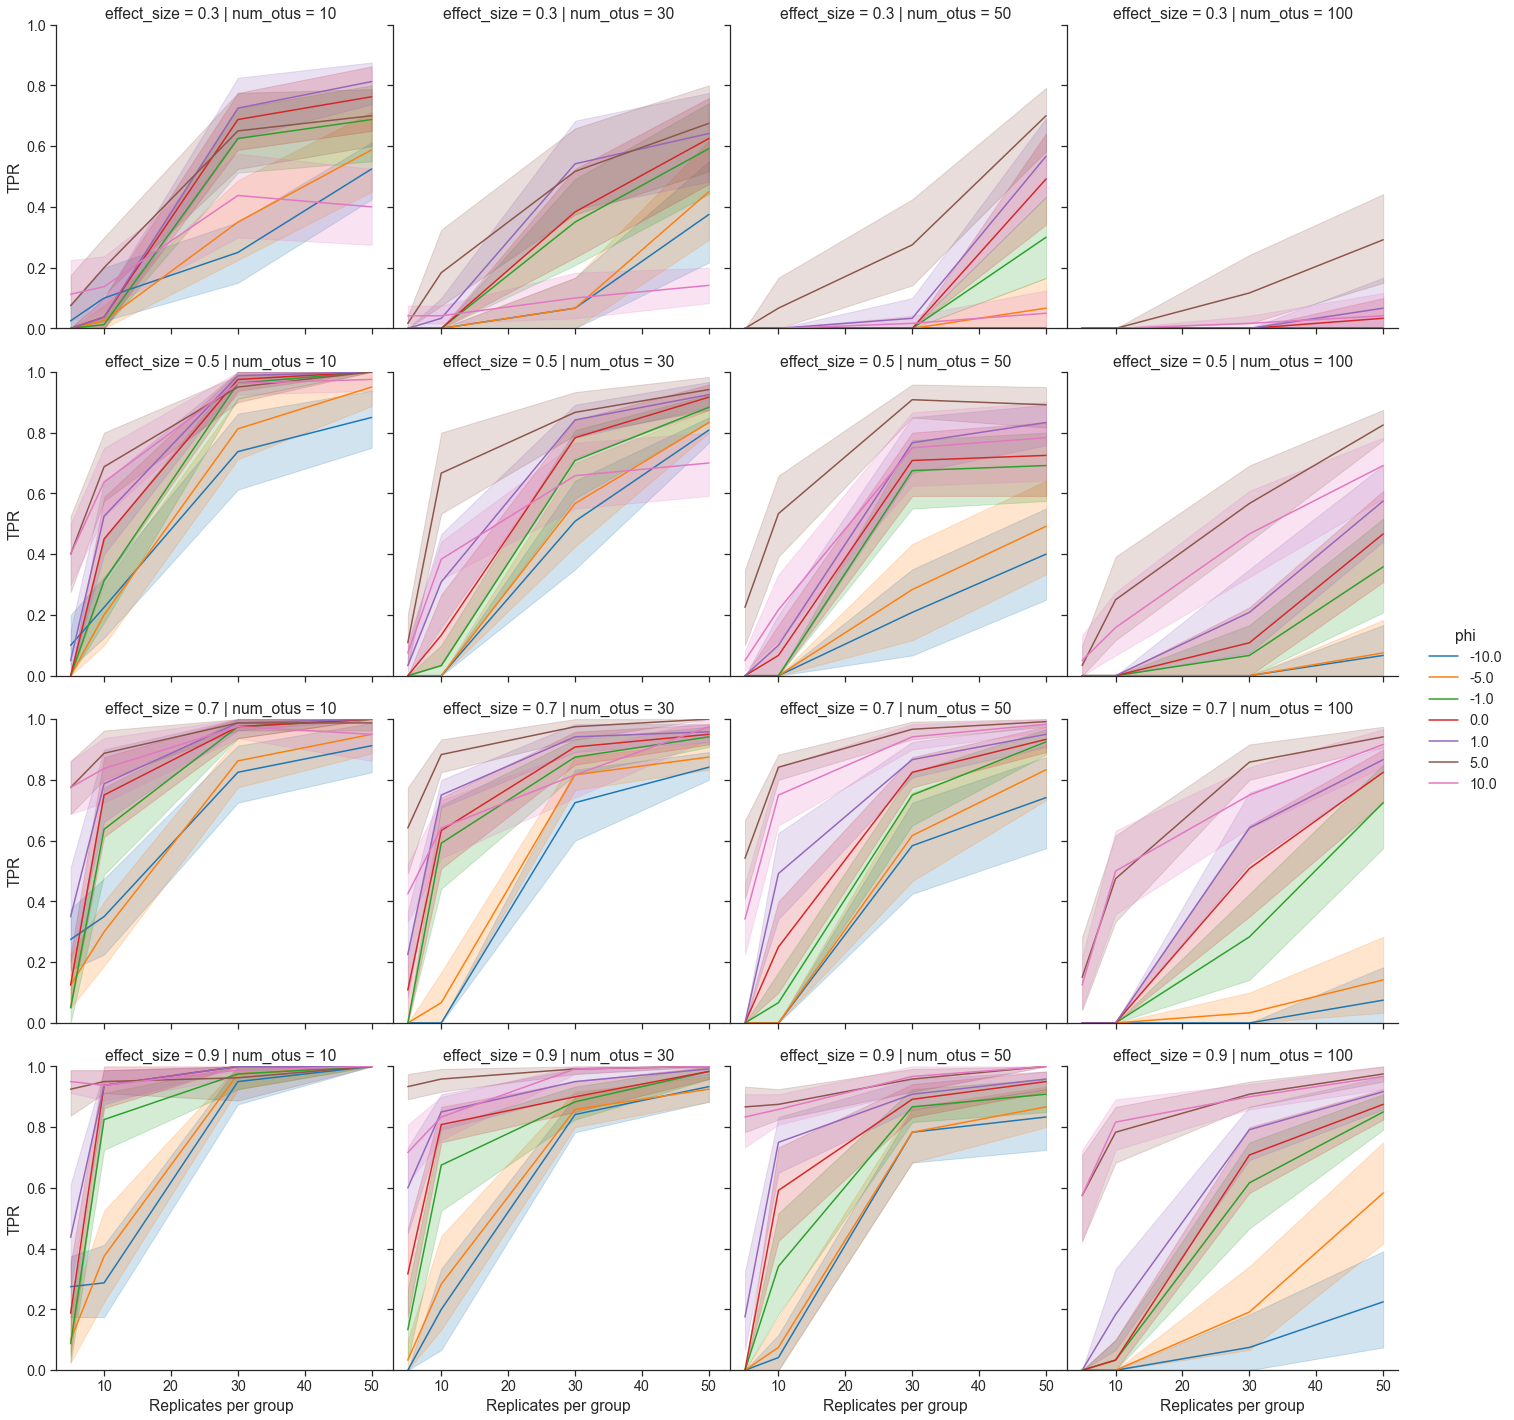

In [13]:
g = sns.relplot(data=tree_agg_df, x="num_samples", y="tpr",
                hue="phi",
                palette="tab10",
                col="num_otus",
                row="effect_size",
                kind="line",
                legend=True
            )
g.set(ylim=[0,1])

# g.axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,)

(g.set_axis_labels("Replicates per group", "TPR").tight_layout(w_pad=0))
plt.show()


## Merged results

In [34]:
def get_num_eff(row):
    if row["model"] in ["tree_agg", "adaANCOM"]:
        return len([int(x) for x in eval(row["result_nodes"])])
    else:
        return len([int(x) for x in eval(row["result_otus"])])

In [37]:
res_full = pd.concat([all_dfs, tree_agg_df]).fillna(0)

num_eff =  classes = res_full.apply(get_num_eff, axis=1)
res_full["num_effects"] = num_eff + 0.001
res_full["hamming"] = res_full["fn"] + res_full["fp"]
res_full

model result_nodes result_otus  dataset_id effect_nodes  \
0   adaANCOM           []          []           0   [12  4  0]   
1   adaANCOM       ['12']  ['9', '7']           1   [12  4  0]   
2   adaANCOM           []          []           2   [12  4  0]   
3   adaANCOM           []          []           3   [12  4  0]   
4   adaANCOM           []          []           4   [12  4  0]   
..       ...          ...         ...         ...          ...   
45  tree_agg       ['45']        [45]         745  [61, 40, 5]   
46  tree_agg       ['40']        [40]         746  [61, 40, 5]   
47  tree_agg           []          []         747  [61, 40, 5]   
48  tree_agg        ['5']         [5]         748  [61, 40, 5]   
49  tree_agg           []          []         749  [61, 40, 5]   

                effect_otus  num_samples  effect_size  num_otus  tp  ...  \
0                 [8 0 4 7]            5          0.3        10   0  ...   
1                 [8 0 4 7]            5          0.3        10   1  ...   
2                 [8 0 4 7]            5          0.3        10   0  ...   
3                 [8 0 4 7]            5          0.3        10   0  ...   
4                 [8 0 4 7]            5          0.3        10   0  ...   
..                      ...          ...          ...       ...  ..  ...   
45  [5, 40, 44, 45, 46, 47]           10          0.5        50   1  ...   
46  [5, 40, 44, 45, 46, 47]           10          0.5        50   1  ...   
47  [5, 40, 44, 45, 46, 47]           10          0.5        50   0  ...   
48  [5, 40, 44, 45, 46, 47]           10          0.5        50   1  ...   
49  [5, 40, 44, 45, 46, 47]           10          0.5        50   0  ...   

      youden  f1_score       mcc  reg_method  lambda   phi  mean_log_prob  \
0   0.000000  0.000000  0.000000           0     0.0   0.0       0.000000   
1   0.083333  0.333333  0.102062           0     0.0   0.0       0.000000   
2   0.000000  0.000000  0.000000           0     0.0   0.0       0.000000   
3   0.000000  0.000000  0.000000           0     0.0   0.0       0.000000   
4   0.000000  0.000000  0.000000           0     0.0   0.0       0.000000   
..       ...       ...       ...         ...     ...   ...            ...   
45  0.166667  0.285714  0.386859       new_3     0.0  10.0   -5926.021540   
46  0.166667  0.285714  0.386859       new_3     0.0  10.0   -5834.394197   
47  0.000000  0.000000  0.000000       new_3     0.0  10.0   -5697.796030   
48  0.166667  0.285714  0.386859       new_3     0.0  10.0   -5917.720165   
49  0.000000  0.000000  0.000000       new_3     0.0  10.0   -5874.866712   

    acc_rate  num_effects  hamming  
0    0.00000        0.001        4  
1    0.00000        1.001        4  
2    0.00000        0.001        4  
3    0.00000        0.001        4  
4    0.00000        0.001        4  
..       ...          ...      ...  
45   0.85775        1.001        5  
46   0.85165        1.001        5  
47   0.84470        0.001        6  
48   0.84350        1.001        5  
49   0.84970        0.001        6  

[17920 rows x 28 columns]

In [38]:
palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']
ticks = [(2,1), (2,1,2,4), (2,1,2,1,2,4), "", (4,1,1,1), (4,1,2,1), (4,1,4,1)]

colors = {
    "adaANCOM": 2,
    "ANCOM": 3,
    "ANCOMBC": 4,
    "sccoda": 1,
    "alr_ttest": 6,
    "alr_wilcoxon": 7,
    "ALDEx2": 5,
    "tree_agg": 0,
}

linestyles = {
    "adaANCOM": 0,
    "ANCOM": 0,
    "ANCOMBC": 1,
    "sccoda": 1,
    "alr_ttest": 0,
    "alr_wilcoxon": 1,
    "ALDEx2": 2,
    "tree_agg": 0,
}
linestyles_phi = {
    0: 3,
    -10: 0,
    -5: 1,
    -1: 2,
    1: 4,
    5: 5,
    10: 6
}
res_full["color"] = [colors[m] for m in res_full["model"]]
res_full["style"] = [linestyles[m] for m in res_full["model"]]
res_full["style_phi"] = [linestyles_phi[p] for p in res_full["phi"]]
res_full["Replicates per group"] = res_full["num_samples"]
res_full["p"] = res_full["num_otus"]
res_full

leg_labels_=["Model", "tascCODA", "scCODA", "adaANCOM", "ANCOM", "ANCOM-BC", "ALDEx2", "ALR + t-test", "ALR + Wilcoxon",
             r"$\phi$", "-10", "-5", "-1", "0", "1", "5", "10"]

plot_path = "./plots/"

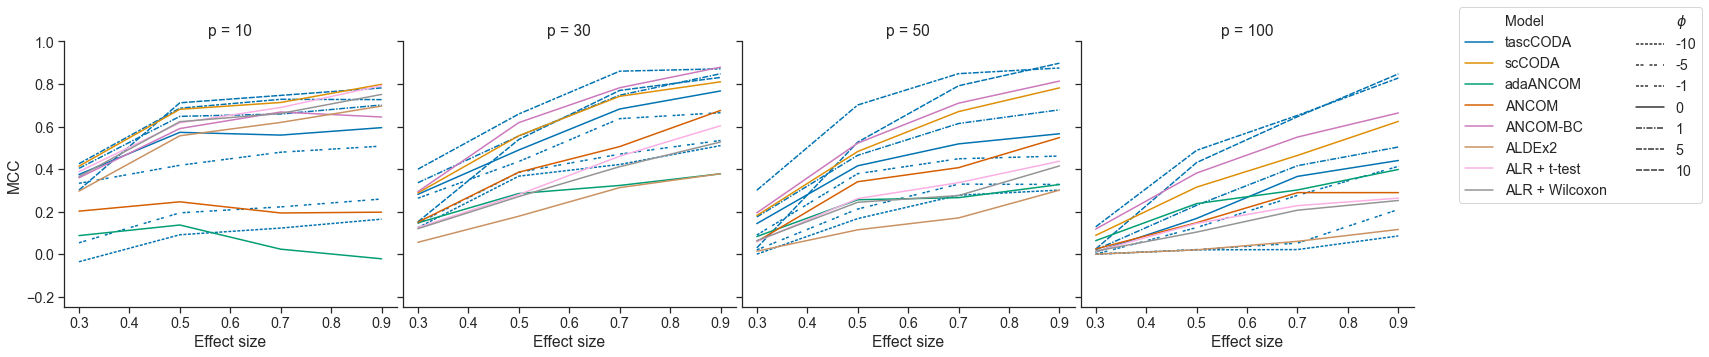

In [18]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_full, x="effect_size", y="mcc",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                # row="num_otus",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(ylim=[-0.25,1])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "MCC").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_mcc_4facets.svg", bbox_inches="tight", format="svg")
plt.show()


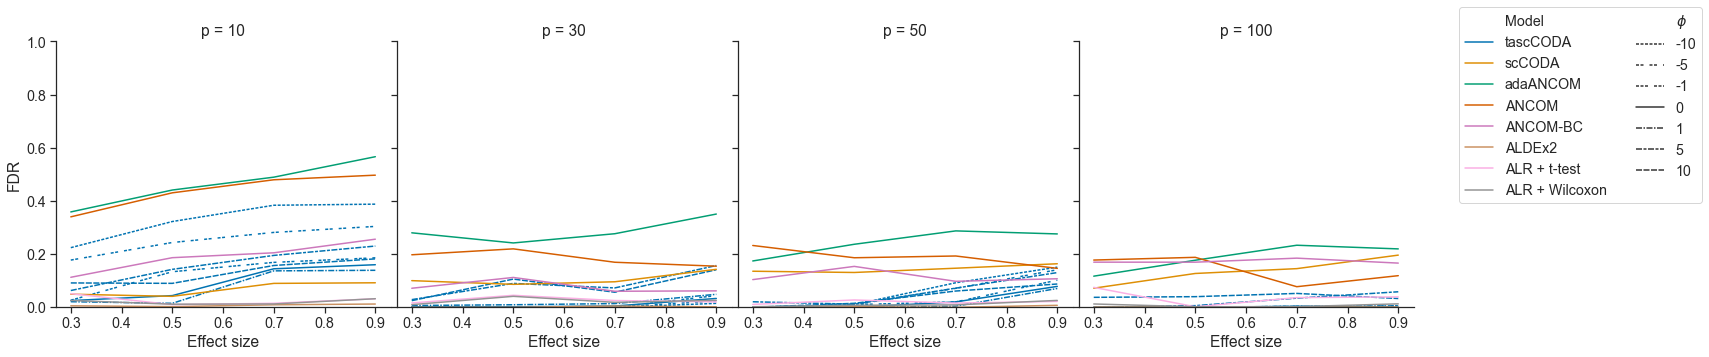

In [19]:
g = sns.relplot(data=res_full, x="effect_size", y="fdr",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                # row="num_otus",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(ylim=[0,1])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "FDR").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_fdr_4facets.svg", bbox_inches="tight", format="svg")
plt.show()

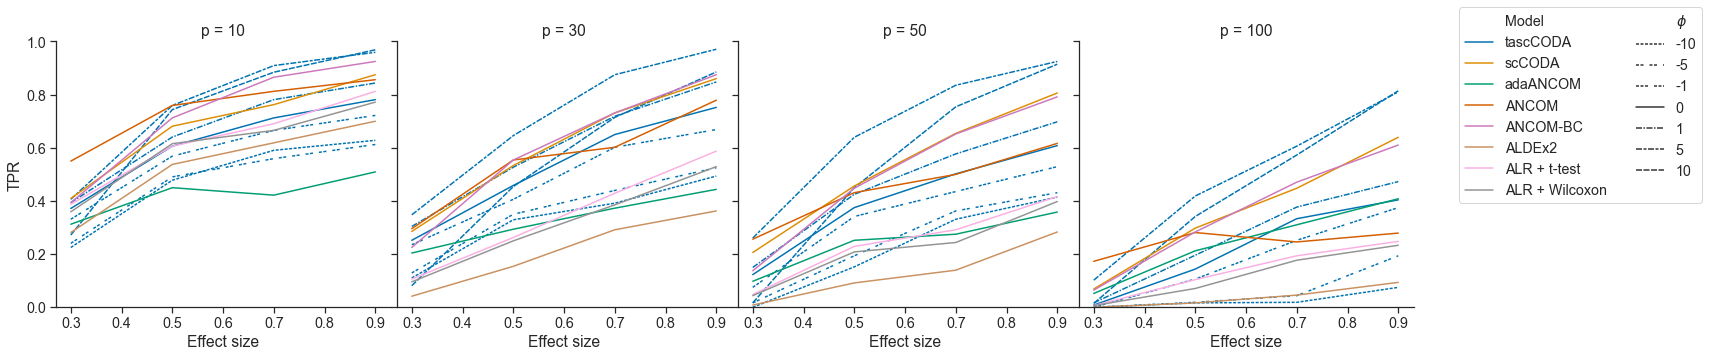

In [20]:
g = sns.relplot(data=res_full, x="effect_size", y="tpr",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                # row="num_otus",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(ylim=[0,1])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

(g.set_axis_labels("Effect size", "TPR").tight_layout(w_pad=0))

plt.savefig(plot_path + "model_comp_tpr_4facets.svg", bbox_inches="tight", format="svg")
plt.show()

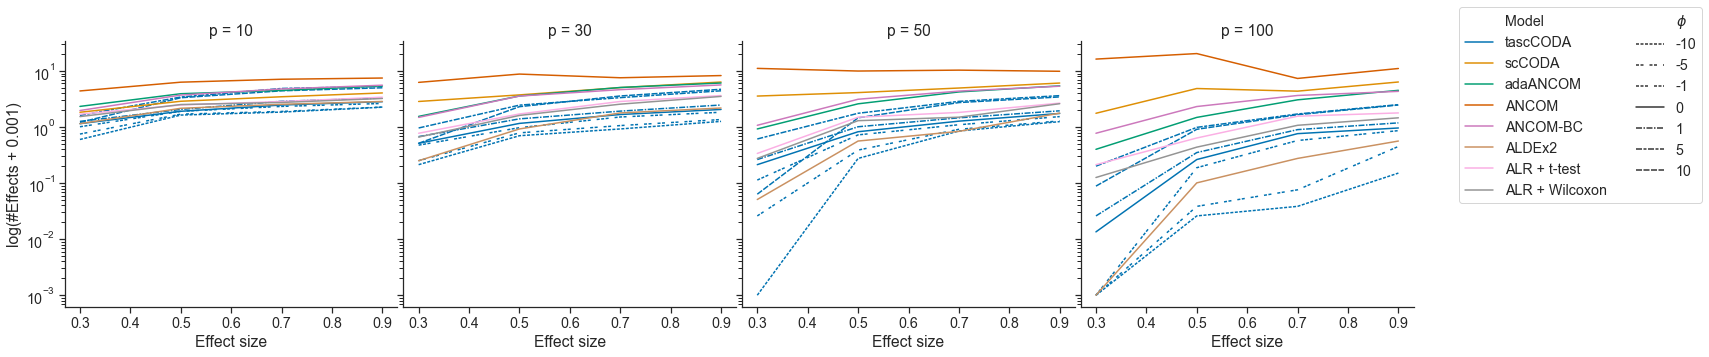

In [21]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_full, x="effect_size", y="num_effects",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                # row="num_otus",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(yscale="log")
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "log(#Effects + 0.001)").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_effects_4facets.svg", bbox_inches="tight", format="svg")
plt.show()

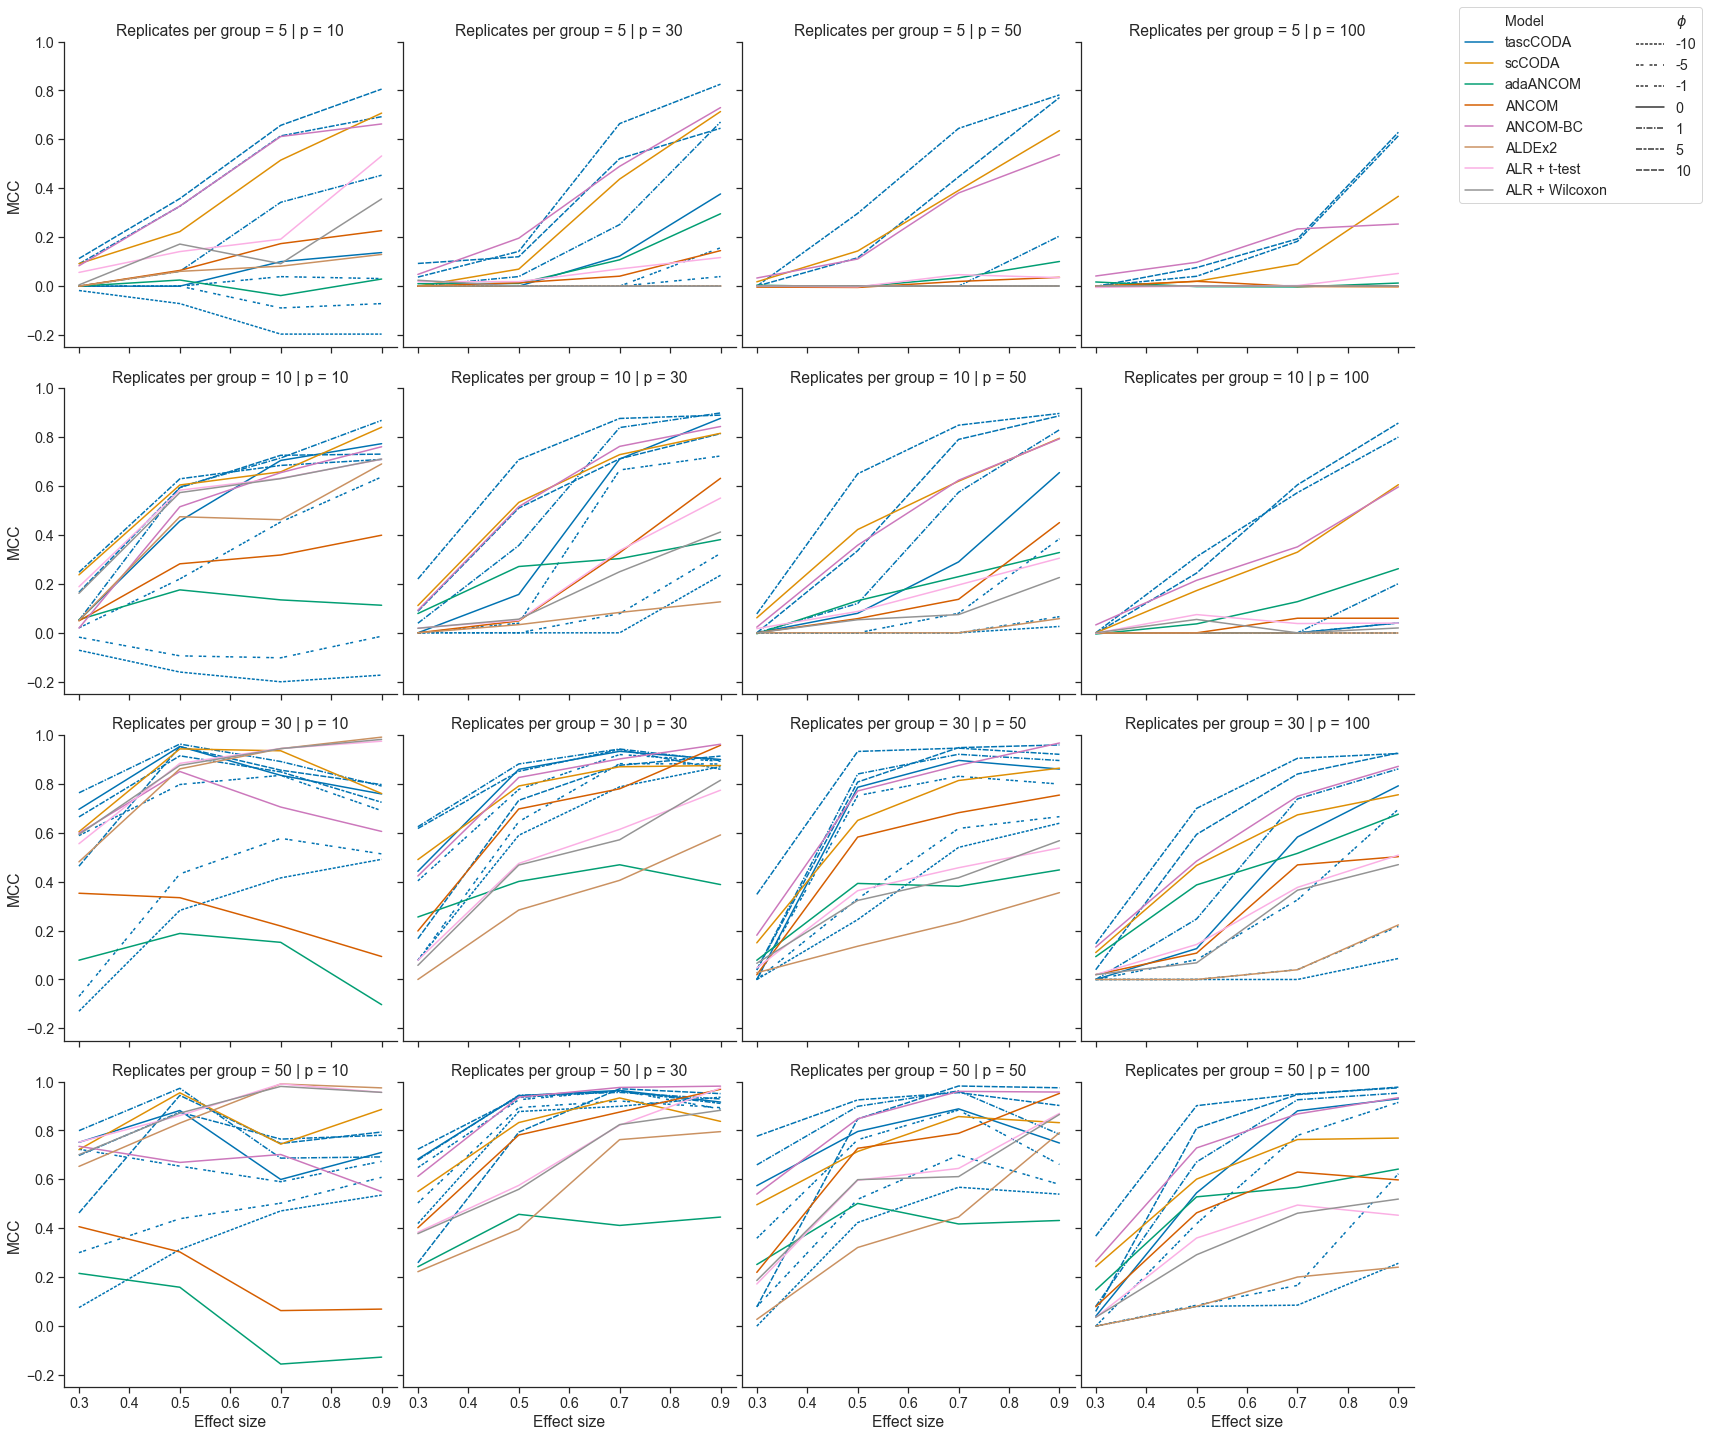

In [22]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_full, x="effect_size", y="mcc",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                row="Replicates per group",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(ylim=[-0.25,1])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "MCC").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_mcc_16facets.svg", bbox_inches="tight", format="svg")
plt.show()


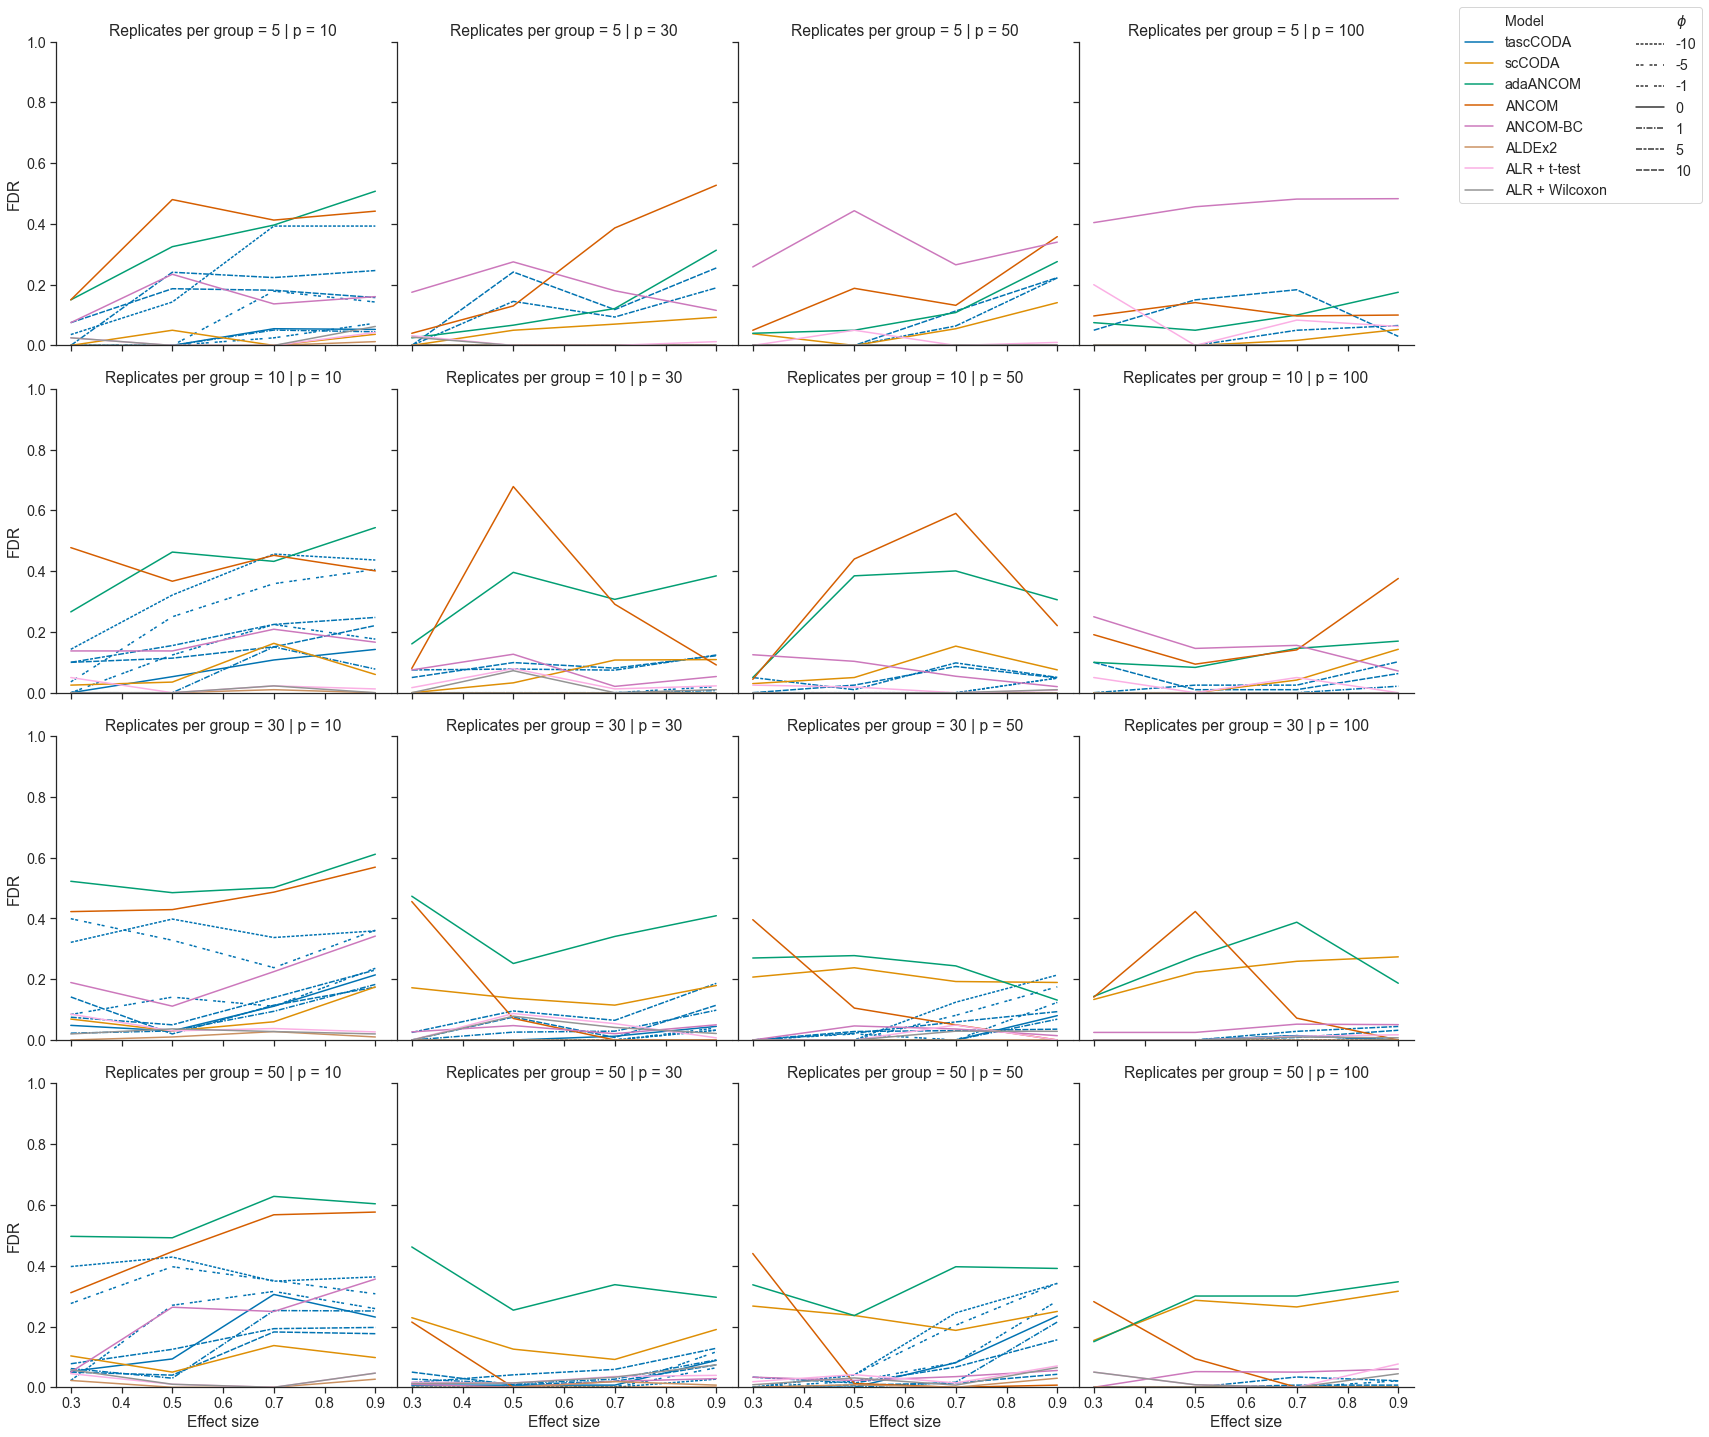

In [23]:
g = sns.relplot(data=res_full, x="effect_size", y="fdr",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                row="Replicates per group",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(ylim=[0,1])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "FDR").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_fdr_16facets.svg", bbox_inches="tight", format="svg")
plt.show()

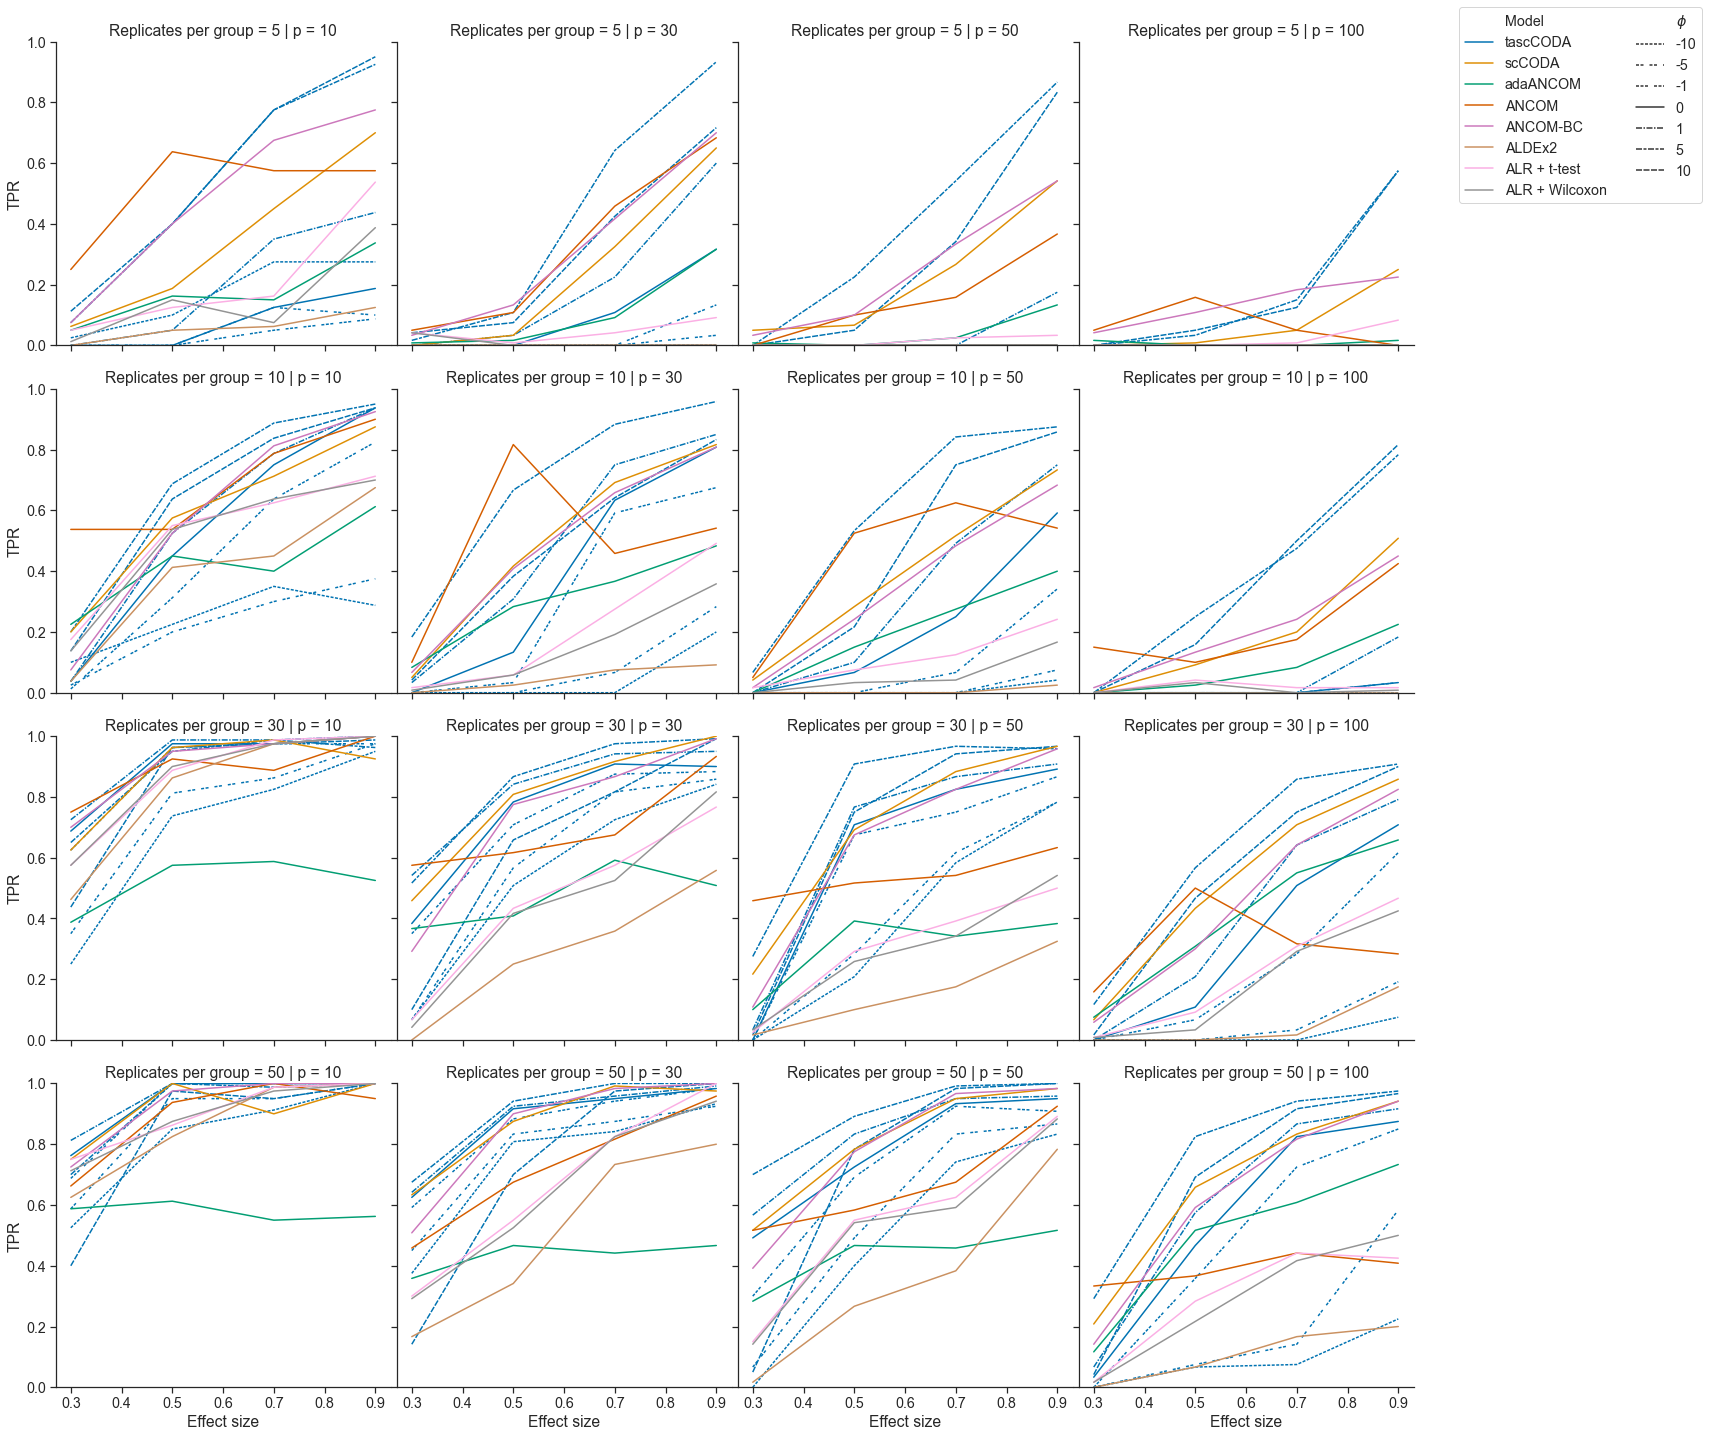

In [24]:
g = sns.relplot(data=res_full, x="effect_size", y="tpr",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                row="Replicates per group",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(ylim=[0,1])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

(g.set_axis_labels("Effect size", "TPR").tight_layout(w_pad=0))

plt.savefig(plot_path + "model_comp_tpr_16facets.svg", bbox_inches="tight", format="svg")
plt.show()

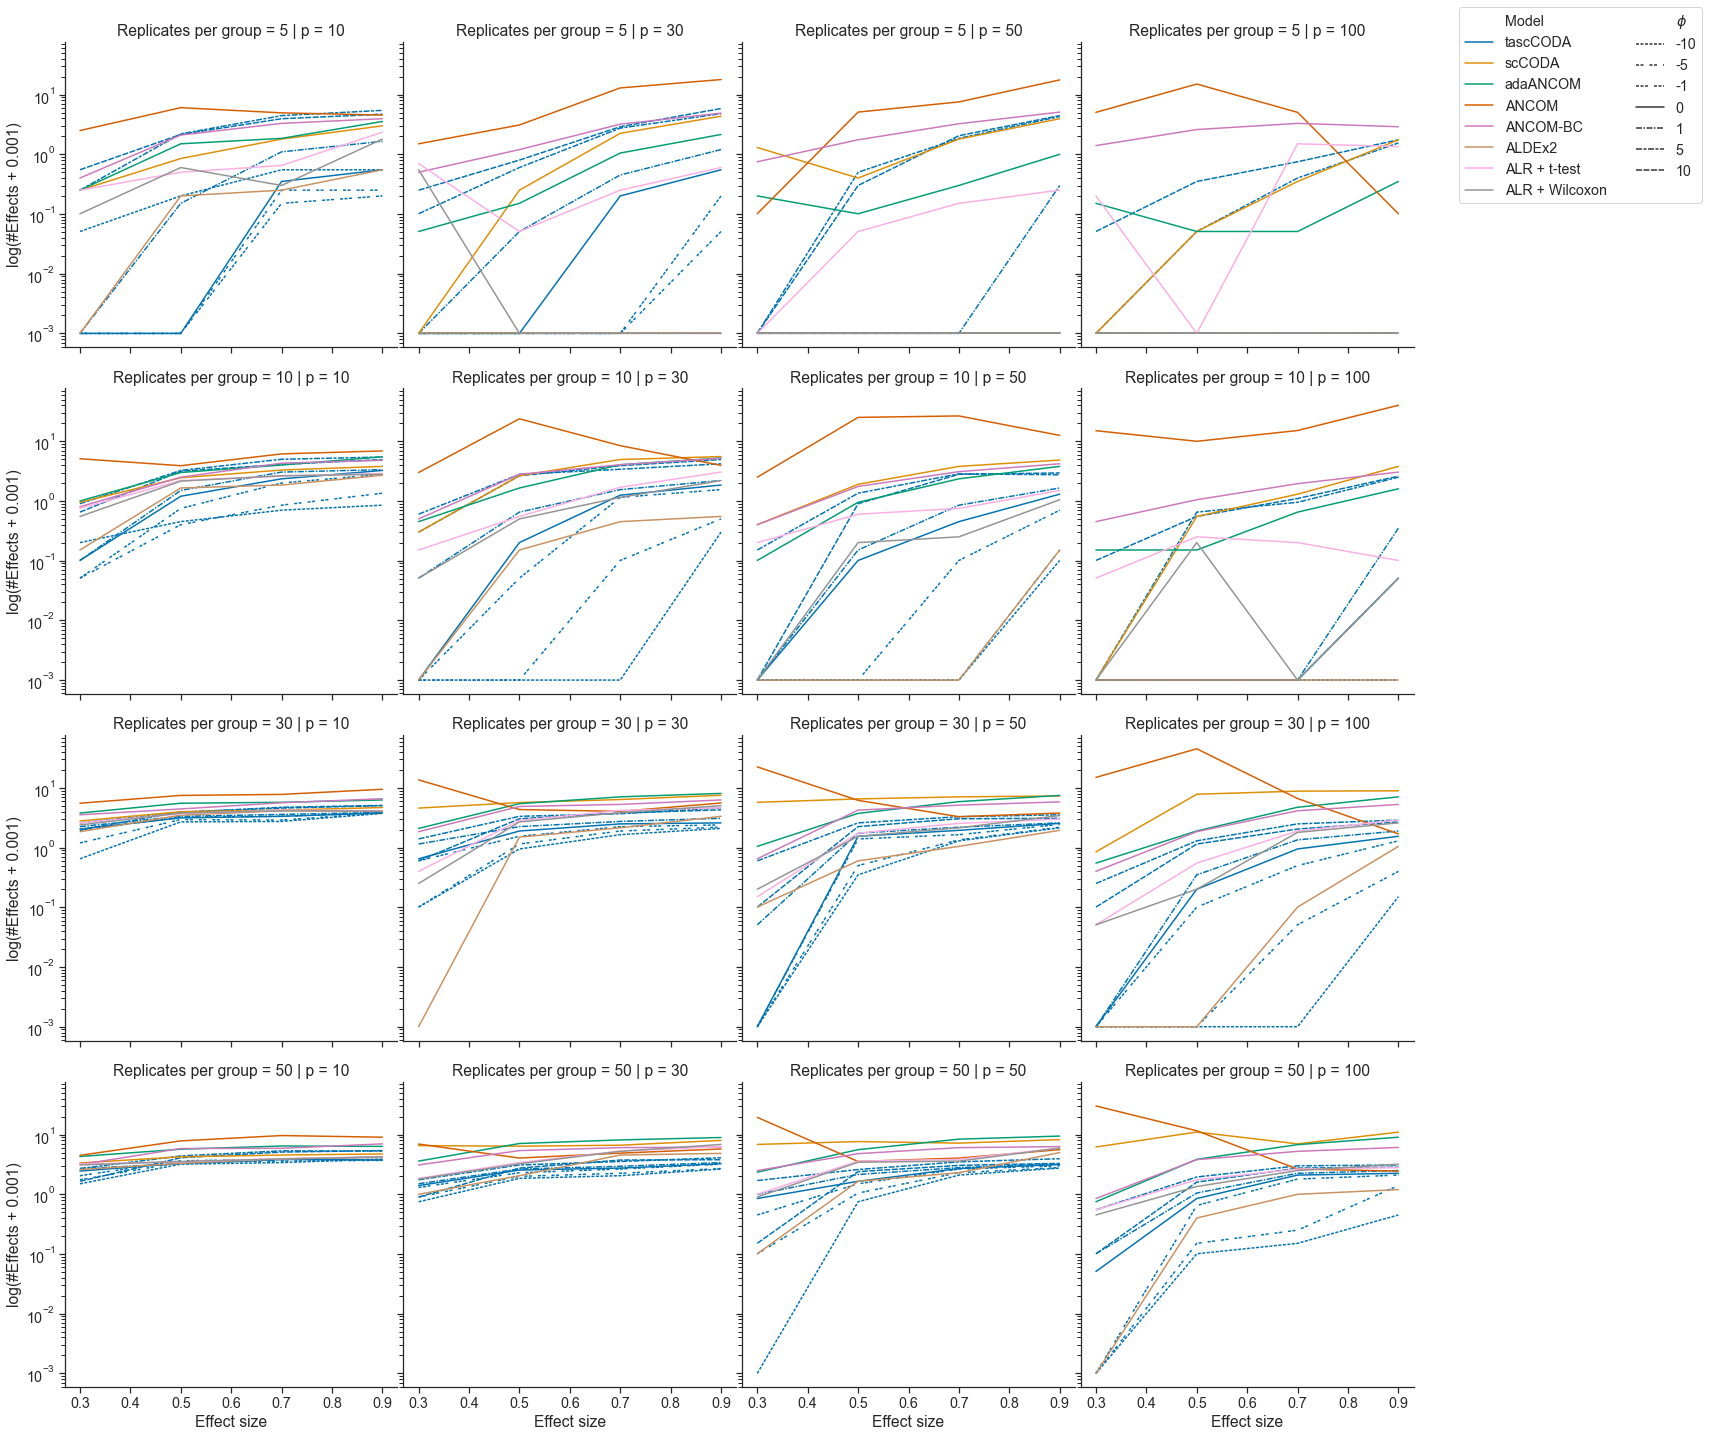

In [25]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_full, x="effect_size", y="num_effects",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                row="Replicates per group",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(yscale="log")
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "log(#Effects + 0.001)").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_effects_16facets.svg", bbox_inches="tight", format="svg")
plt.show()

In [26]:
print(res_full[(res_full["p"]==100) & (res_full["effect_size"]==0.7) & (res_full["model"]=="adaANCOM")])

         model                                       result_nodes  \
1120  adaANCOM                                                 []   
1121  adaANCOM                                                 []   
1122  adaANCOM                                                 []   
1123  adaANCOM                                                 []   
1124  adaANCOM                                                 []   
...        ...                                                ...   
1195  adaANCOM  ['101', '102', '103', '106', '109', '121', '13...   
1196  adaANCOM         ['133', '134', '143', '163', '164', '168']   
1197  adaANCOM  ['101', '103', '104', '105', '141', '144', '14...   
1198  adaANCOM         ['108', '127', '130', '143', '151', '199']   
1199  adaANCOM                                     ['109', '114']   

                                            result_otus  dataset_id  \
1120                                       ['40', '38']        1120   
1121                         

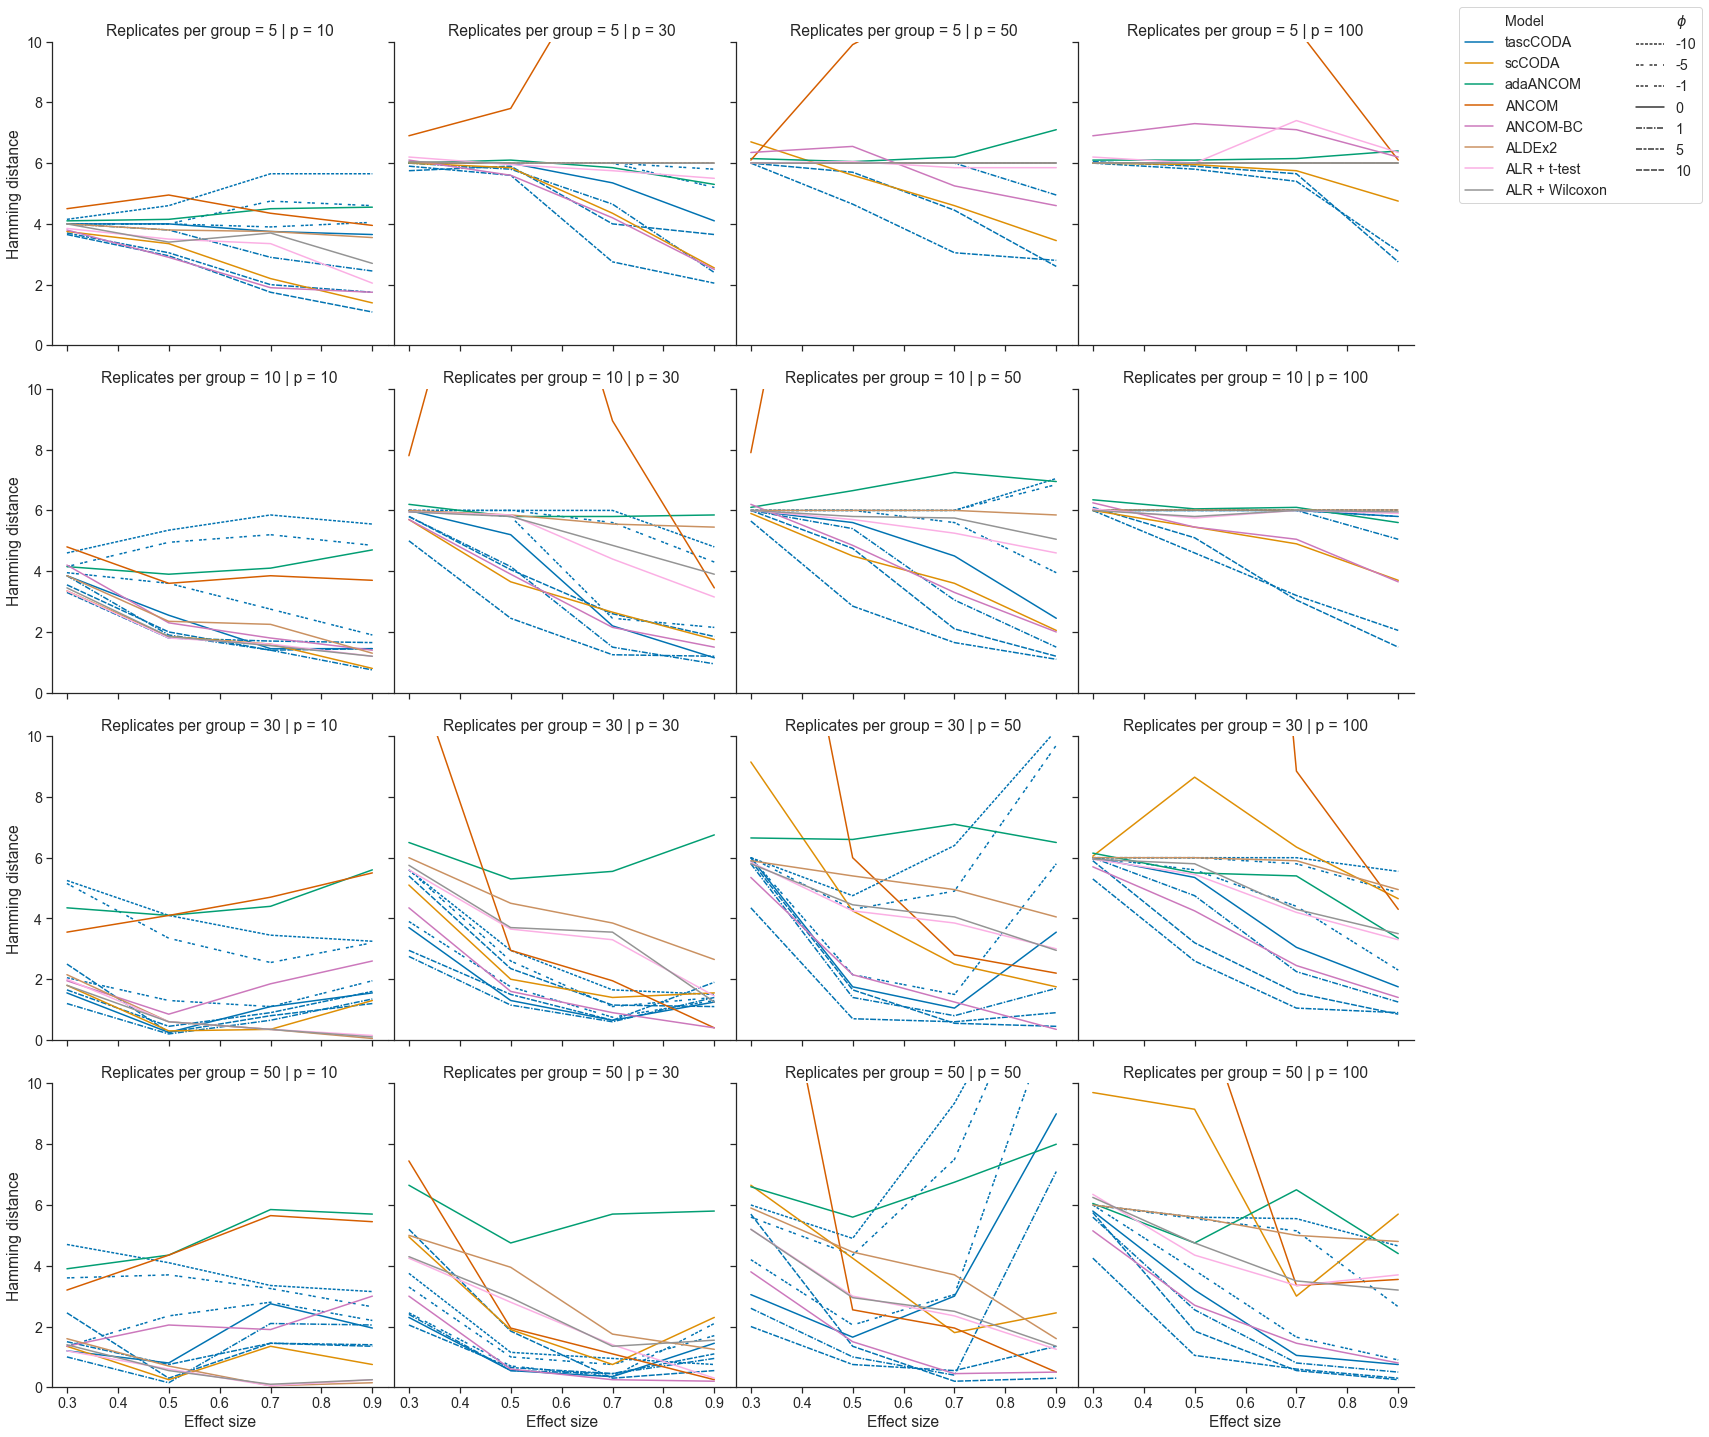

In [41]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_full, x="effect_size", y="hamming",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                row="Replicates per group",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
# g.set(yscale="log")
g.set(ylim=[0,10])

g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "Hamming distance").tight_layout(w_pad=0))
# plt.savefig(plot_path + "model_comp_effects_16facets.svg", bbox_inches="tight", format="svg")
plt.show()

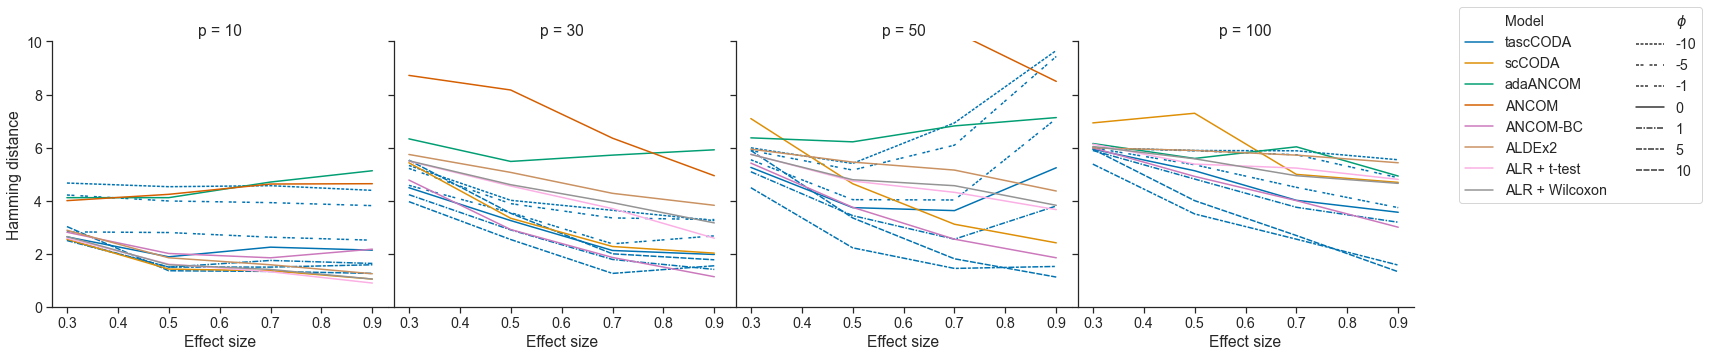

In [42]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_full, x="effect_size", y="hamming",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                # row="Replicates per group",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
# g.set(yscale="log")
g.set(ylim=[0,10])

g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "Hamming distance").tight_layout(w_pad=0))
# plt.savefig(plot_path + "model_comp_effects_16facets.svg", bbox_inches="tight", format="svg")
plt.show()

In [60]:
print(res_full[
          (res_full["num_otus"]==50) &
          (res_full["model"]=="tree_agg") &
          (res_full["phi"] == -5) &
          (res_full["effect_size"] == 0.9) &
          (res_full["num_samples"] == 50)
      ])

       model                   result_nodes  \
0   tree_agg                    ['5', '61']   
1   tree_agg                   ['40', '61']   
2   tree_agg        ['5', '40', '61', '67']   
3   tree_agg  ['5', '40', '61', '65', '67']   
4   tree_agg                         ['61']   
5   tree_agg  ['5', '40', '61', '65', '67']   
6   tree_agg                         ['61']   
7   tree_agg        ['5', '61', '65', '67']   
8   tree_agg                         ['61']   
9   tree_agg              ['5', '40', '61']   
40  tree_agg                         ['61']   
41  tree_agg        ['5', '40', '61', '67']   
42  tree_agg              ['5', '40', '61']   
43  tree_agg  ['5', '40', '61', '65', '67']   
44  tree_agg              ['5', '61', '67']   
45  tree_agg                         ['61']   
46  tree_agg                         ['61']   
47  tree_agg              ['5', '40', '61']   
48  tree_agg  ['5', '40', '61', '65', '67']   
49  tree_agg                    ['5', '61']   

            

In [55]:
all_r = {}
for i in range(181):
    with open(tree_agg_path + f"exact_results/results_tree_agg_new_3_{i}.pkl", "rb") as f:
        r_ = pkl.load(f)
        all_r.update(r_)

In [59]:
print(all_r.keys())

dict_keys([(0, 'tree_agg', 'new_3', None, -10.0), (1, 'tree_agg', 'new_3', None, -10.0), (2, 'tree_agg', 'new_3', None, -10.0), (3, 'tree_agg', 'new_3', None, -10.0), (4, 'tree_agg', 'new_3', None, -10.0), (5, 'tree_agg', 'new_3', None, -10.0), (6, 'tree_agg', 'new_3', None, -10.0), (7, 'tree_agg', 'new_3', None, -10.0), (8, 'tree_agg', 'new_3', None, -10.0), (9, 'tree_agg', 'new_3', None, -10.0), (10, 'tree_agg', 'new_3', None, -10.0), (11, 'tree_agg', 'new_3', None, -10.0), (12, 'tree_agg', 'new_3', None, -10.0), (13, 'tree_agg', 'new_3', None, -10.0), (14, 'tree_agg', 'new_3', None, -10.0), (15, 'tree_agg', 'new_3', None, -10.0), (16, 'tree_agg', 'new_3', None, -10.0), (17, 'tree_agg', 'new_3', None, -10.0), (18, 'tree_agg', 'new_3', None, -10.0), (19, 'tree_agg', 'new_3', None, -10.0), (20, 'tree_agg', 'new_3', None, -10.0), (21, 'tree_agg', 'new_3', None, -10.0), (22, 'tree_agg', 'new_3', None, -10.0), (23, 'tree_agg', 'new_3', None, -10.0), (24, 'tree_agg', 'new_3', None, -10.0),

In [70]:
test_r = all_r[(952, "tree_agg", "new_3", None, -10)]
test_r[2].loc[[("x_0_node", str(j)) for j in np.arange(51,69) if j != 55], :]

Final Parameter  Median  HDI 3%  HDI 97%     SD     Delta  \
Covariate Node                                                              
x_0_node  51              0.000   0.001  -0.022    0.028  0.012  0.044577   
          52              0.000   0.000  -0.019    0.026  0.012  0.044532   
          53              0.000  -0.000  -0.024    0.022  0.011  0.044494   
          54              0.000  -0.001  -0.028    0.015  0.012  0.044494   
          56              0.000  -0.001  -0.026    0.014  0.010  0.044532   
          57              0.000  -0.000  -0.028    0.025  0.013  0.044463   
          58              0.000  -0.003  -0.050    0.014  0.018  0.044633   
          59              0.000   0.000  -0.024    0.021  0.011  0.044633   
          60              0.000   0.000  -0.024    0.022  0.012  0.044577   
          61              0.821   0.821   0.735    0.906  0.046  0.044532   
          62              0.000   0.000   0.000    0.000  0.000  0.000000   
          63              0.000   0.000  -0.035    0.039  0.017  0.049746   
          64              0.000  -0.001  -0.031    0.015  0.012  0.044633   
          65              0.000  -0.014  -0.089    0.014  0.031  0.046950   
          66              0.000   0.000   0.000    0.000  0.000  0.000000   
          67             -0.069  -0.069  -0.137   -0.004  0.037  0.058407   
          68              0.000   0.000   0.000    0.000  0.000  0.000000   

                Is significant  
Covariate Node                  
x_0_node  51             False  
          52             False  
          53             False  
          54             False  
          56             False  
          57             False  
          58             False  
          59             False  
          60             False  
          61              True  
          62             False  
          63             False  
          64             False  
          65             False  
          66             False  
          67              True  
          68             False

In [71]:
test_r = all_r[(955, "tree_agg", "new_3", None, -10)]
test_r[2].loc[[("x_0_node", str(j)) for j in np.arange(51,69) if j != 55], :]

Final Parameter  Median  HDI 3%  HDI 97%     SD     Delta  \
Covariate Node                                                              
x_0_node  51              0.000   0.001  -0.026    0.029  0.014  0.042699   
          52              0.000  -0.000  -0.024    0.021  0.011  0.042652   
          53              0.000  -0.001  -0.042    0.023  0.018  0.042613   
          54              0.000  -0.001  -0.034    0.018  0.014  0.042613   
          56              0.000   0.000  -0.024    0.028  0.013  0.042652   
          57              0.000  -0.000  -0.024    0.021  0.011  0.042581   
          58              0.000  -0.008  -0.082    0.016  0.028  0.042757   
          59              0.000  -0.000  -0.024    0.023  0.012  0.042757   
          60              0.000   0.000  -0.020    0.021  0.010  0.042699   
          61              0.728   0.728   0.623    0.834  0.057  0.042652   
          62              0.000   0.000   0.000    0.000  0.000  0.000000   
          63              0.000  -0.026  -0.122    0.014  0.042  0.047995   
          64              0.000   0.000  -0.022    0.029  0.014  0.042757   
          65             -0.067  -0.067  -0.154    0.006  0.049  0.045139   
          66              0.000   0.000   0.000    0.000  0.000  0.000000   
          67             -0.076  -0.076  -0.170    0.012  0.055  0.056766   
          68              0.000   0.000   0.000    0.000  0.000  0.000000   

                Is significant  
Covariate Node                  
x_0_node  51             False  
          52             False  
          53             False  
          54             False  
          56             False  
          57             False  
          58             False  
          59             False  
          60             False  
          61              True  
          62             False  
          63             False  
          64             False  
          65              True  
          66             False  
          67              True  
          68             False

In [75]:
test_r = all_r[(957, "tree_agg", "new_3", None, -10)]
test_r[2].loc[[("x_0_node", str(j)) for j in np.arange(51,69) if j != 55], :]

Final Parameter  Median  HDI 3%  HDI 97%     SD     Delta  \
Covariate Node                                                              
x_0_node  51              0.000  -0.000  -0.020    0.019  0.010  0.049256   
          52              0.000  -0.000  -0.024    0.023  0.012  0.049214   
          53              0.000   0.001  -0.020    0.042  0.017  0.049180   
          54              0.000  -0.000  -0.027    0.017  0.012  0.049180   
          56              0.000  -0.000  -0.022    0.021  0.011  0.049214   
          57              0.000  -0.000  -0.022    0.015  0.010  0.049152   
          58              0.000  -0.000  -0.035    0.016  0.014  0.049307   
          59              0.000  -0.001  -0.030    0.019  0.014  0.049307   
          60              0.000   0.001  -0.017    0.029  0.012  0.049256   
          61              0.641   0.641   0.518    0.774  0.068  0.049214   
          62              0.000   0.000   0.000    0.000  0.000  0.000000   
          63              0.000  -0.000  -0.045    0.027  0.018  0.054108   
          64              0.000  -0.000  -0.023    0.019  0.011  0.049307   
          65             -0.109  -0.109  -0.194    0.005  0.058  0.051460   
          66              0.000   0.000   0.000    0.000  0.000  0.000000   
          67             -0.139  -0.139  -0.238   -0.023  0.055  0.062495   
          68              0.000   0.000   0.000    0.000  0.000  0.000000   

                Is significant  
Covariate Node                  
x_0_node  51             False  
          52             False  
          53             False  
          54             False  
          56             False  
          57             False  
          58             False  
          59             False  
          60             False  
          61              True  
          62             False  
          63             False  
          64             False  
          65              True  
          66             False  
          67              True  
          68             False

In [81]:
test_r = all_r[(1274, "tree_agg", "new_3", None, -10)]
test_r[2].loc[[("x_0_node", str(j)) for j in np.arange(101, 142) if j not in [105, 117, 119, 130, 136, 138]], :]

Final Parameter  Median  HDI 3%  HDI 97%     SD     Delta  \
Covariate Node                                                              
x_0_node  101             0.000  -0.000  -0.013    0.011  0.006  0.074693   
          102             0.000   0.000  -0.010    0.012  0.006  0.074685   
          103             0.000   0.000  -0.010    0.013  0.006  0.074678   
          104             0.000  -0.000  -0.011    0.009  0.006  0.074678   
          106             0.000   0.000  -0.011    0.012  0.006  0.074678   
          107             0.000  -0.000  -0.012    0.010  0.006  0.074672   
          108             0.000  -0.000  -0.012    0.009  0.005  0.074678   
          109             0.000  -0.000  -0.015    0.010  0.007  0.074685   
          110             0.000  -0.000  -0.012    0.011  0.006  0.074678   
          111             0.000  -0.000  -0.011    0.010  0.006  0.074678   
          112             0.000  -0.000  -0.012    0.009  0.006  0.074678   
          113             0.757   0.757   0.658    0.853  0.052  0.074678   
          114             0.000   0.000  -0.009    0.010  0.005  0.074672   
          115             0.000  -0.000  -0.011    0.009  0.005  0.074672   
          116             0.000  -0.000  -0.011    0.010  0.005  0.074667   
          118             0.000   0.000  -0.010    0.012  0.006  0.074672   
          120             0.000   0.000  -0.010    0.022  0.010  0.074672   
          121             0.000  -0.000  -0.011    0.008  0.005  0.074693   
          122             0.000  -0.000  -0.018    0.010  0.007  0.074685   
          123             0.000  -0.001  -0.015    0.008  0.007  0.074678   
          124             0.000   0.000  -0.011    0.012  0.006  0.074667   
          125             0.000   0.000  -0.010    0.013  0.006  0.074667   
          126             0.000   0.000   0.000    0.000  0.000  0.000000   
          127             0.000  -0.001  -0.015    0.010  0.007  0.074880   
          128             0.000   0.000  -0.011    0.012  0.006  0.074721   
          129             0.000  -0.000  -0.011    0.011  0.005  0.074701   
          131             0.000  -0.000  -0.017    0.009  0.007  0.074721   
          132             0.000  -0.000  -0.016    0.010  0.007  0.074710   
          133             0.000   0.000  -0.010    0.016  0.007  0.074701   
          134             0.000  -0.000  -0.015    0.012  0.007  0.074693   
          135             0.000   0.000  -0.011    0.012  0.006  0.074678   
          137             0.000  -0.001  -0.024    0.009  0.009  0.074909   
          139             0.000  -0.001  -0.021    0.011  0.008  0.076755   
          140             0.000   0.000  -0.013    0.014  0.007  0.076541   
          141             0.000   0.000   0.000    0.000  0.000  0.000000   

                Is significant  
Covariate Node                  
x_0_node  101            False  
          102            False  
          103            False  
          104            False  
          106            False  
          107            False  
          108            False  
          109            False  
          110            False  
          111            False  
          112            False  
          113             True  
          114            False  
          115            False  
          116            False  
          118            False  
          120            False  
          121            False  
          122            False  
          123            False  
          124            False  
          125            False  
          126            False  
          127            False  
          128            False  
          129            False  
          131            False  
          132            False  
          133            False  
          134            False  
          135            False  
          137            False  
          139            False  
          1

In [82]:
test_r = all_r[(317, "tree_agg", "new_3", None, -10)]
test_r[2].loc[[("x_0_node", str(j)) for j in [10, 11, 12, 14, 15]], :]

Final Parameter  Median  HDI 3%  HDI 97%     SD     Delta  \
Covariate Node                                                              
x_0_node  10              0.000   0.006  -0.030    0.070  0.026  0.019853   
          11              0.000  -0.002  -0.051    0.019  0.018  0.016051   
          12              0.606   0.606   0.408    0.800  0.107  0.014400   
          14             -0.156  -0.156  -0.325    0.015  0.094  0.054523   
          15              0.000   0.000   0.000    0.000  0.000  0.000000   

                Is significant  
Covariate Node                  
x_0_node  10             False  
          11             False  
          12              True  
          14              True  
          15             False

In [84]:
all_d = {}
for i in np.arange(640, 961):
    with open(f"./data/datasets3/data_{i}", "rb") as f:
        d_ = ad.read_h5ad(f)
        all_d[i] = d_

<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

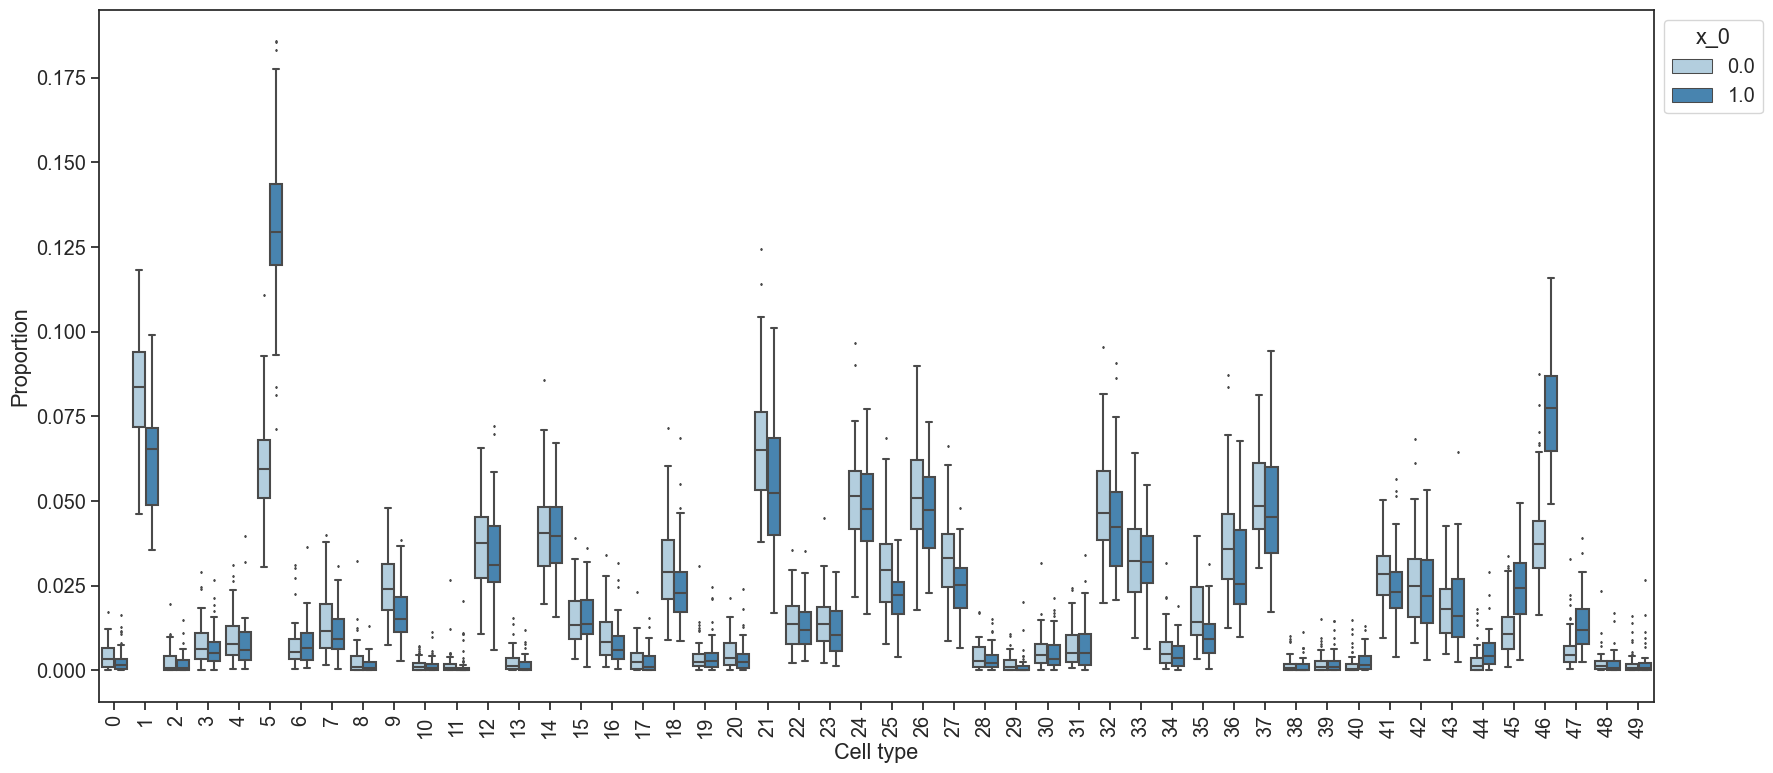

In [88]:
import sccoda.util.data_visualization as viz
viz.boxplots(all_d[957], "x_0", figsize=(18,8))